## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import dp_verification as dp
import aggregation as agg
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
dv = dp.DPVerification(dataset_size=10000)
ag = agg.Aggregation(t=1, repeat_count=10000)

Loaded 10000 records


### Test Parameters

In [3]:
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Wasserstein Distance:  0.0 

DP Predicate Test: False 



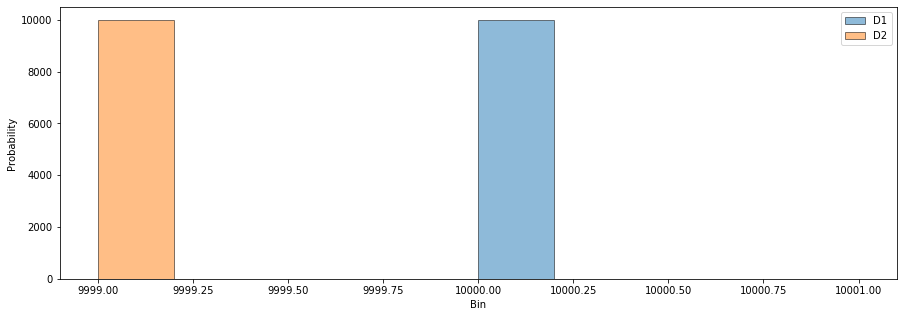

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', binsize = "unity", bound = False, exact = True)

If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10005.00640527369  Stdev fD1:  2.872289302860187  Mean fD2:  10003.992950500719  Stdev fD2:  2.887608362720967

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1074, pvalue=1.2941082951613566e-50) 

Wasserstein Distance:  2.9655172413793096 

DP Predicate Test: False 



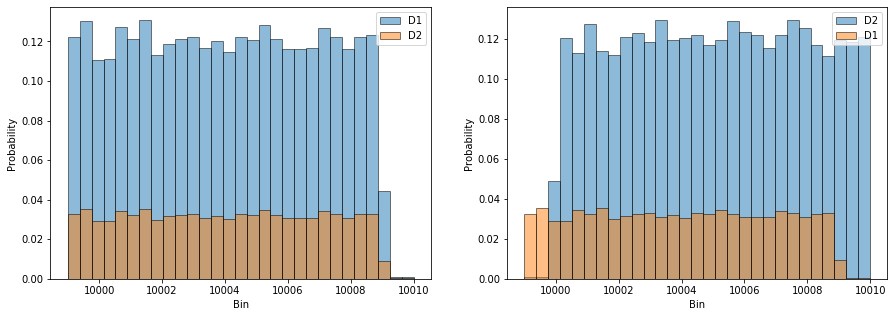

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False,bound = True)

#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.95480932162  Stdev fD1:  5.301563575745068  Mean fD2:  9998.998384731454  Stdev fD2:  5.3200400066447

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0784, pvalue=3.808765148627586e-27) 

Wasserstein Distance:  5.45679012345679 

DP Predicate Test: True 



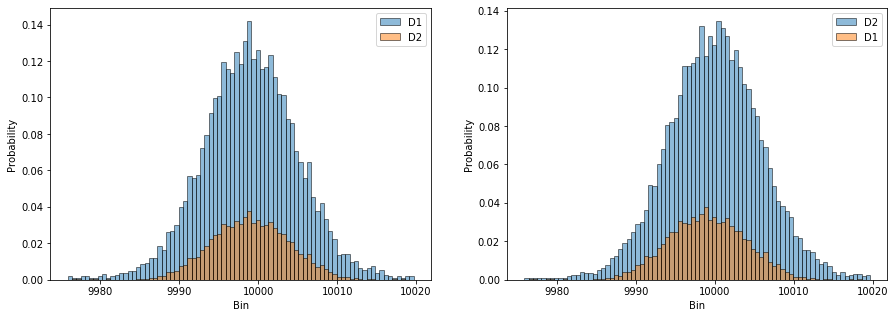

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.054263432346  Stdev fD1:  64.51719634087591  Mean fD2:  20009.962483381896  Stdev fD2:  63.84899576819309

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0275, pvalue=0.0010385517933069264) 

Wasserstein Distance:  4.070588235294117 

DP Predicate Test: True 



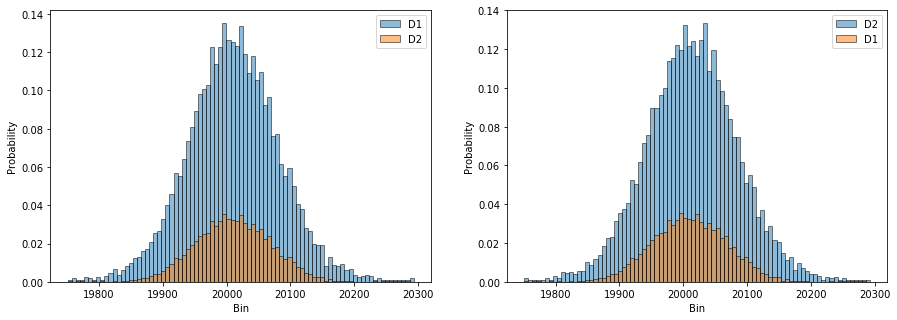

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.001271207718558  Stdev fD1:  0.0064890539614701785  Mean fD2:  2.001484926140308  Stdev fD2:  0.006470230589010468

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0165, pvalue=0.13138496726749369) 

Wasserstein Distance:  5.037974683544304 

DP Predicate Test: True 



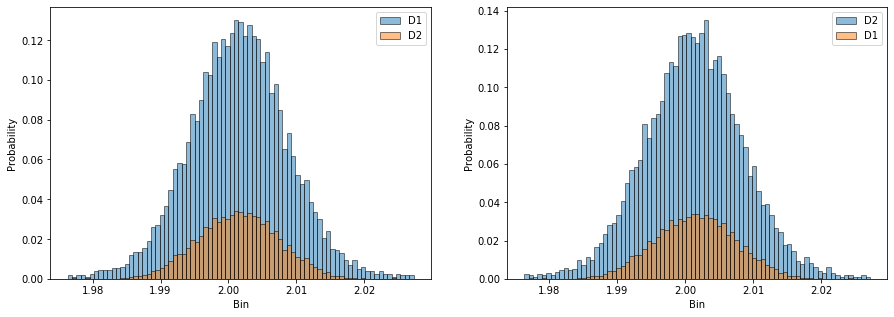

In [8]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', binsize="auto", debug=False, plot=True)

#### Noisy mean passes the DP Predicate test

### Variance Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.0518948383786015  Stdev fD1:  0.09250734414565505  Mean fD2:  2.051949471009194  Stdev fD2:  0.09405594151391301

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0137, pvalue=0.30504141099080584) 

Wasserstein Distance:  6.5352112676056375 

DP Predicate Test: True 



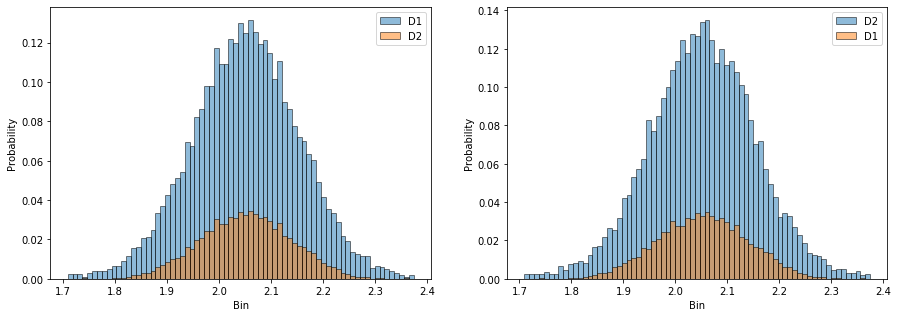

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', binsize="auto", debug=False)

#### Noisy variance passes the DP Predicate test

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.980325412766  Stdev fD1:  5.371379137621207  Mean fD2:  9999.031378543827  Stdev fD2:  5.288191355084051

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28) 

Wasserstein Distance:  4.951219512195123 

DP Predicate Test: True 



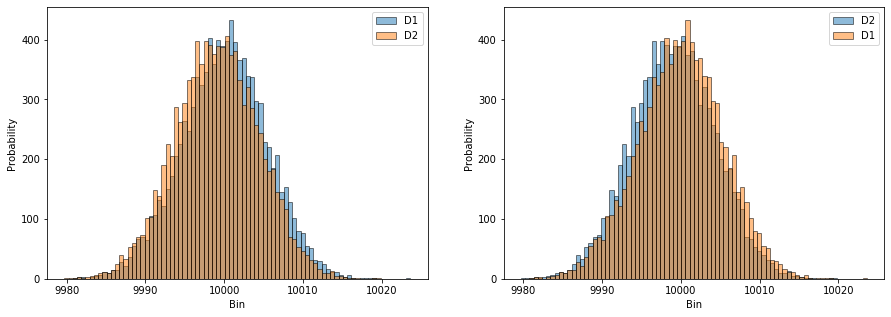

(True,
 Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28),
 4.951219512195123)

In [10]:
dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

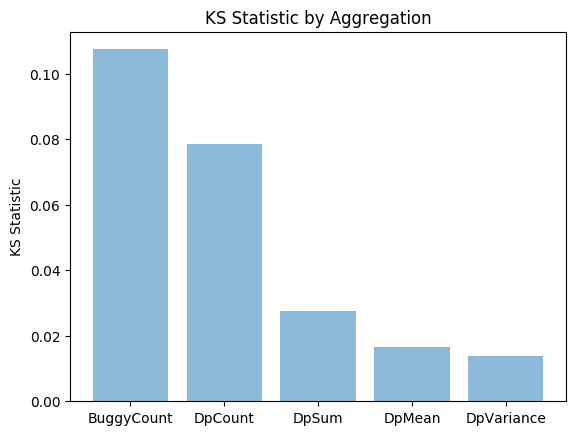

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

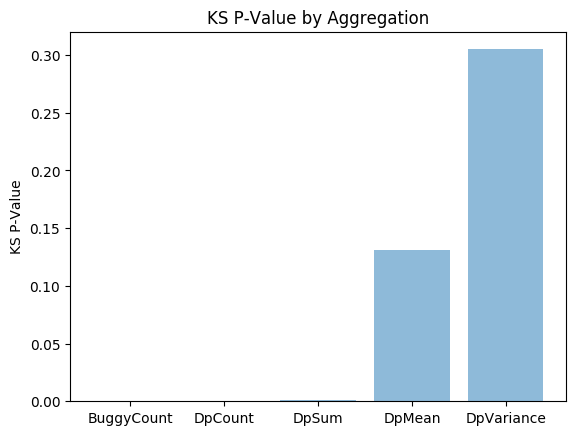

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

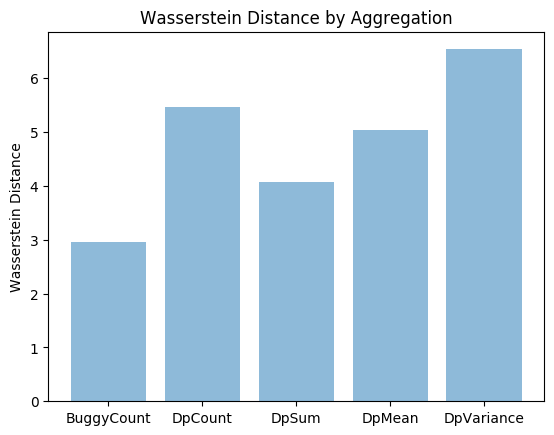

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [14]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.003150446026  Stdev fD1:  5.329548568121991  Mean fD2:  9999.068096604222  Stdev fD2:  5.345181279124184

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0682, pvalue=1.21976233733592e-20) 

Wasserstein Distance:  4.409638554216866 

DP Predicate Test: True 

--- 0.07331061363220215 seconds ---


In [15]:
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.521400350048  Stdev fD1:  64.33678728785993  Mean fD2:  20009.570909004782  Stdev fD2:  63.991294298451635

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0212, pvalue=0.022340230544746754) 

Wasserstein Distance:  5.788235294117644 

DP Predicate Test: True 

--- 0.0722508430480957 seconds ---


In [16]:
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.954461149271  Stdev fD1:  2.8988207643457353  Mean fD2:  10003.953225665098  Stdev fD2:  2.892072355511362

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1069, pvalue=3.793908925840325e-50) 

Wasserstein Distance:  4.689655172413794 

DP Predicate Test: False 

--- 0.09925460815429688 seconds ---


### Verifying Burdock Private Query Mechanism implementation

#### Laplace mechanism - COUNT

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.97551502367  Stdev fD1:  1.4133119023989313  Mean fD2:  9998.993518893049  Stdev fD2:  1.3849513072027044

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.3936, pvalue=0.0) 

Wasserstein Distance:  3.7820512820512797 

DP Predicate Test: True 



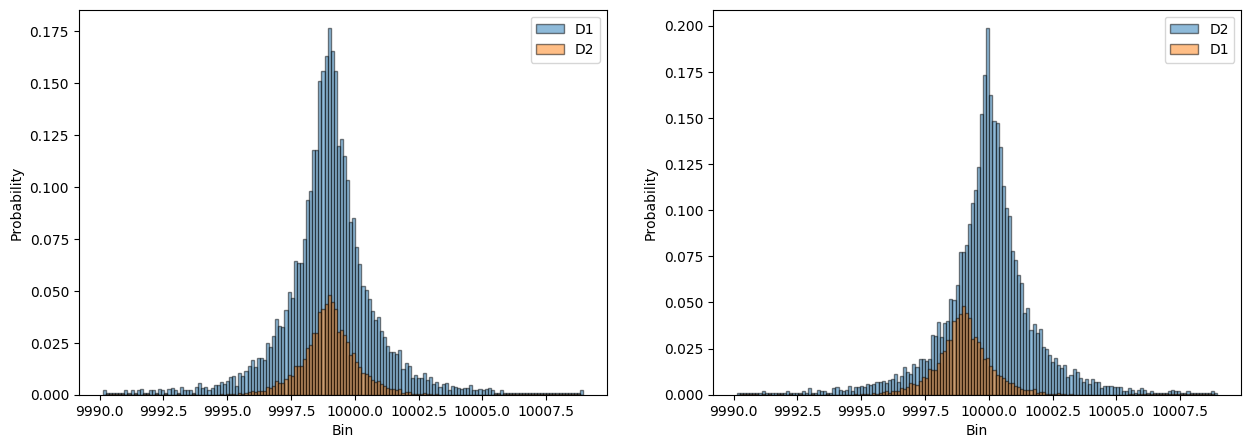

In [17]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Laplace mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.00238263942  Stdev fD1:  16.782865817402346  Mean fD2:  20010.21837504596  Stdev fD2:  16.85383596906529

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1135, pvalue=1.7226653725831867e-56) 

Wasserstein Distance:  3.2760736196319034 

DP Predicate Test: True 



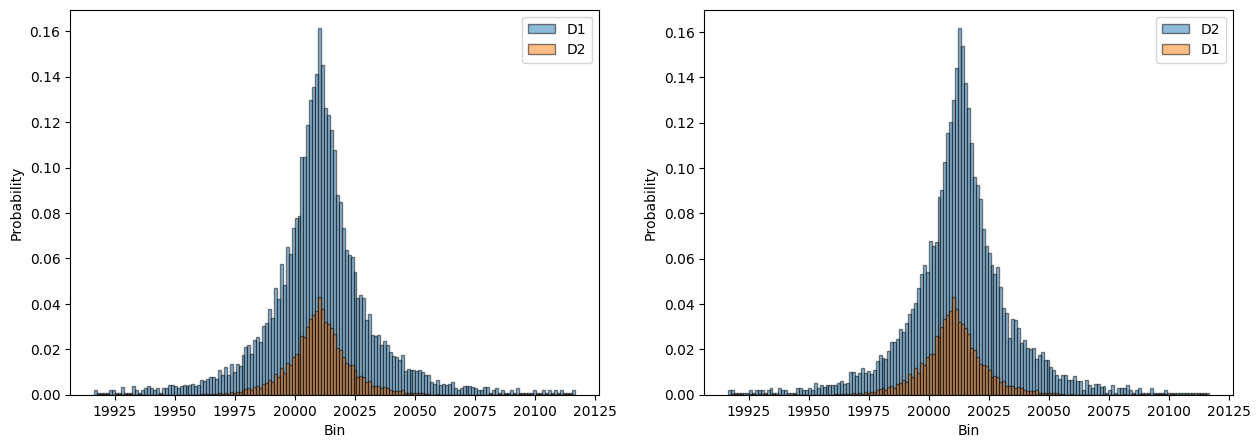

In [18]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

#### Gaussian mechanism - Count

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.933987058184  Stdev fD1:  8.638210791276586  Mean fD2:  9998.9402438048  Stdev fD2:  8.534574686726293

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0507, pvalue=1.3592680509184789e-11) 

Wasserstein Distance:  5.807228915662649 

DP Predicate Test: True 



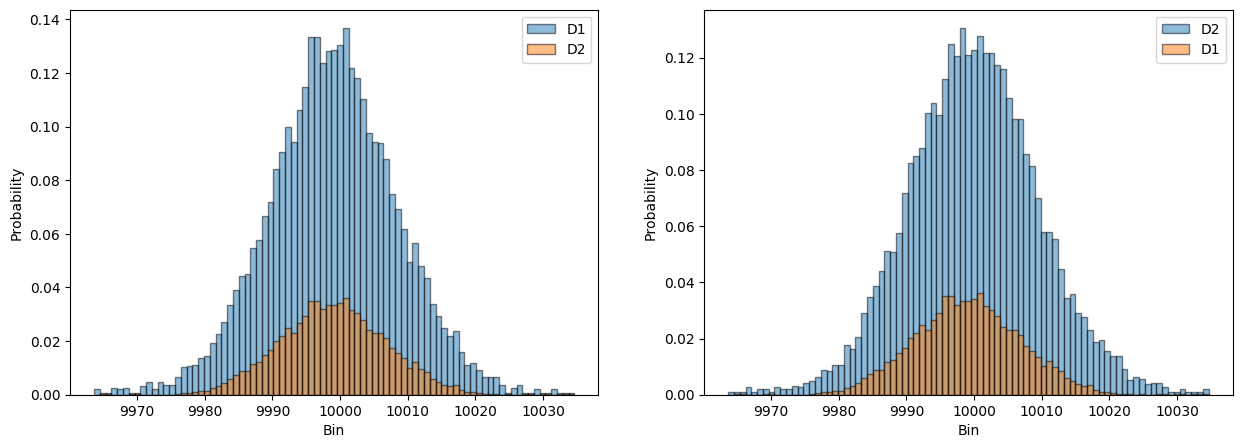

In [19]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Gaussian")
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Gaussian Mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.966324554713  Stdev fD1:  8.690811737768925  Mean fD2:  20012.014406344653  Stdev fD2:  8.57112915815103

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0452, pvalue=2.6646512061620694e-09) 

Wasserstein Distance:  4.3370786516853945 

DP Predicate Test: True 



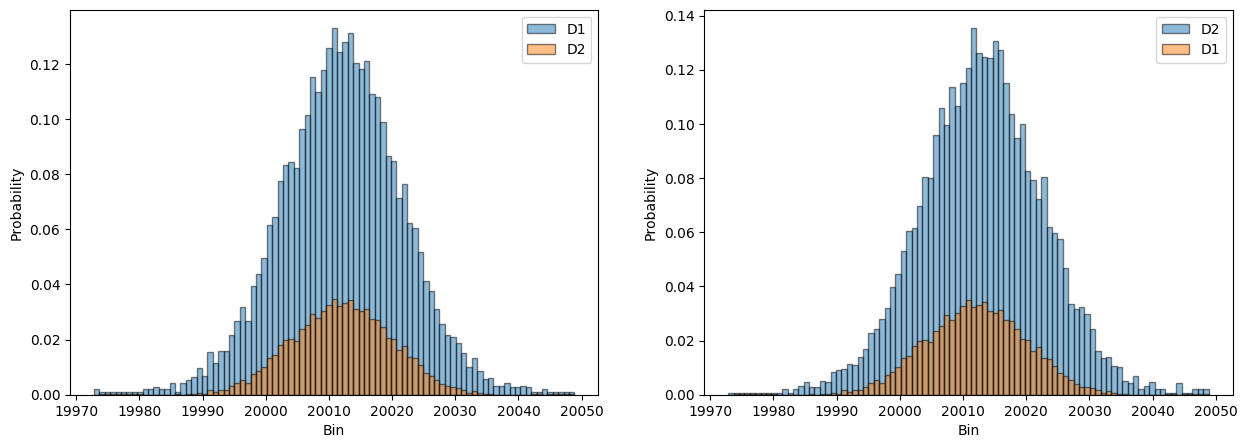

In [20]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

### Verifying Burdock Private Query implementation for a sample query

#### Note: Burdock uses Laplace noise by default right now but has support for both Laplace and Gaussian noise

### SUM DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Count of times noisy result within bounds: 9499 / 10000
Count of times noisy result outside bounds: 501 / 10000
Mean signed deviation:  -2.05866186978464e-05


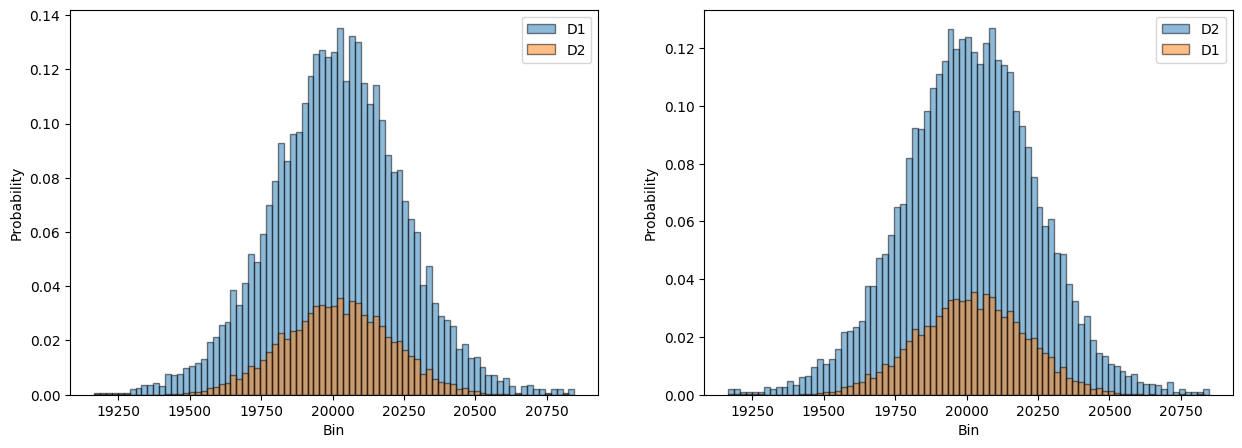

DP Predicate Test:  True
Accuracy Test:  True
Utility Test:  True
Bias Test:  True
--- 19.261035919189453 seconds ---


In [21]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Laplace")
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT SUM(Usage) AS TotalUsage FROM d1.d1"
d2_query = "SELECT SUM(Usage) AS TotalUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### COUNT DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Count of times noisy result within bounds: 9534 / 10000
Count of times noisy result outside bounds: 466 / 10000
Mean signed deviation:  -3.3839999999999994e-05


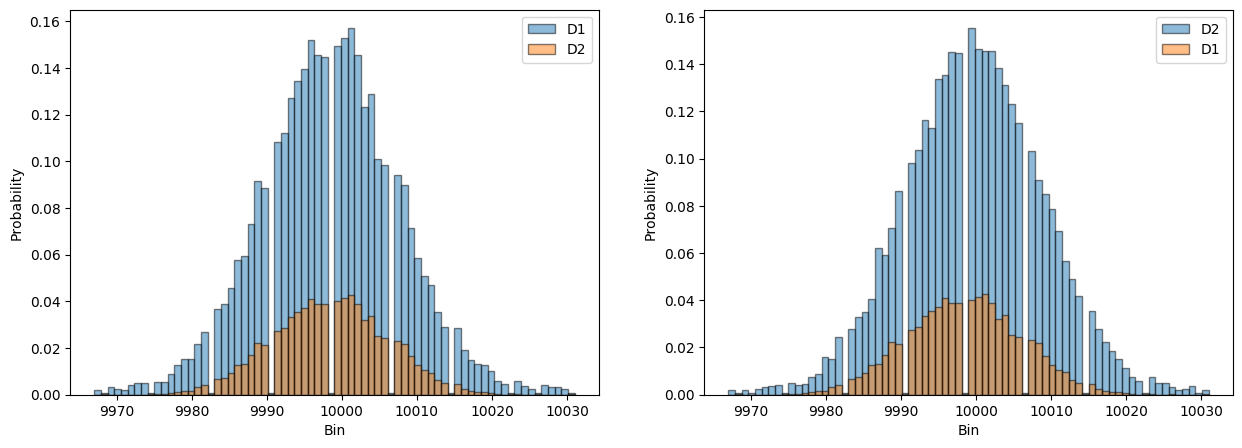

DP Predicate Test:  True
Accuracy Test:  True
Utility Test:  True
Bias Test:  True
--- 18.4480402469635 seconds ---


In [22]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### MEAN DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Count of times noisy result within bounds: 9256 / 10000
Count of times noisy result outside bounds: 744 / 10000
Mean signed deviation:  0.000105287914765717


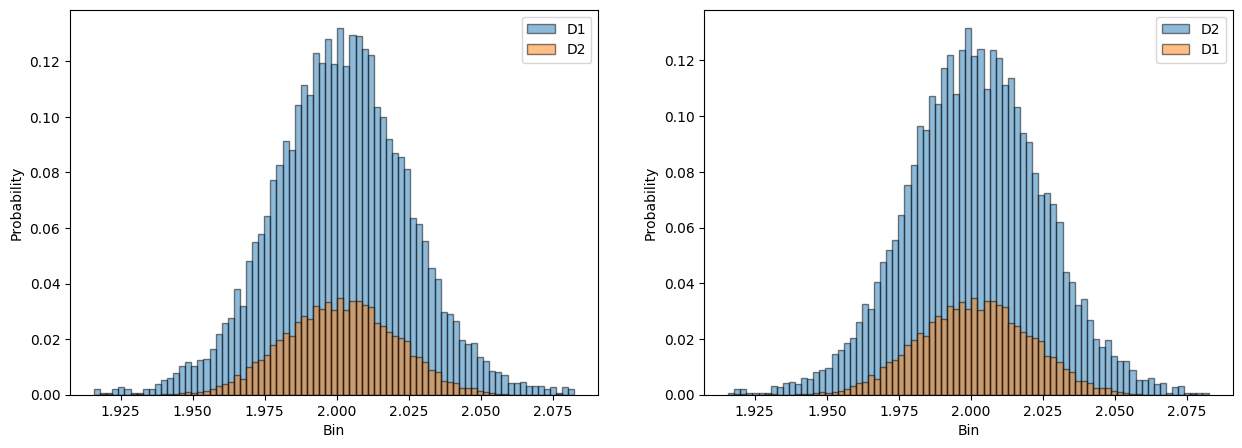

DP Predicate Test:  True
Accuracy Test:  True
Utility Test:  True
Bias Test:  True
--- 65.30471515655518 seconds ---


In [23]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT AVG(Usage) AS AvgUsage FROM d1.d1"
d2_query = "SELECT AVG(Usage) AS AvgUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### VARIANCE DP Predicate Test

VAR is not available in Sqlite. So we can't get exact VAR for doing accuracy, utility and bias tests. 

Length of D1:  10000  Length of D2:  9999
Count of times noisy result within bounds: 116 / 10000
Count of times noisy result outside bounds: 9884 / 10000
Mean signed deviation:  inf


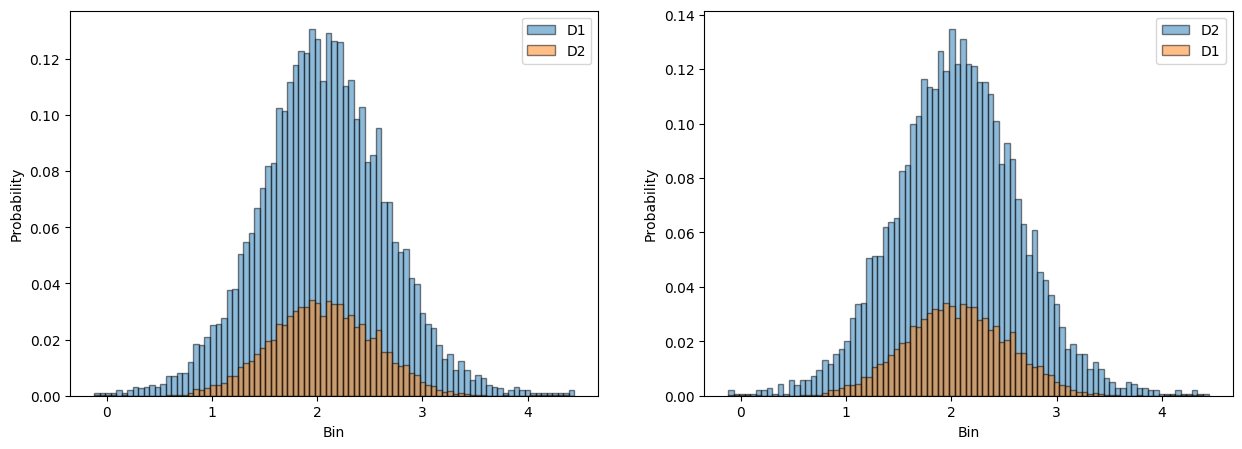

DP Predicate Test:  True
--- 121.20446515083313 seconds ---


In [24]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT VAR(Usage) AS UsageVar FROM d1.d1"
d2_query = "SELECT VAR(Usage) AS UsageVar FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=10000, get_exact=False)
print("DP Predicate Test: ", dp_res)
print("--- %s seconds ---" % (time.time() - start_time))

### GROUP BY Test

Length of D1:  10000  Length of D2:  9999
role       R1
segment     A
Name: 0, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 956 / 1000
Count of times noisy result outside bounds: 44 / 1000
Mean signed deviation:  -0.0001375858123569794


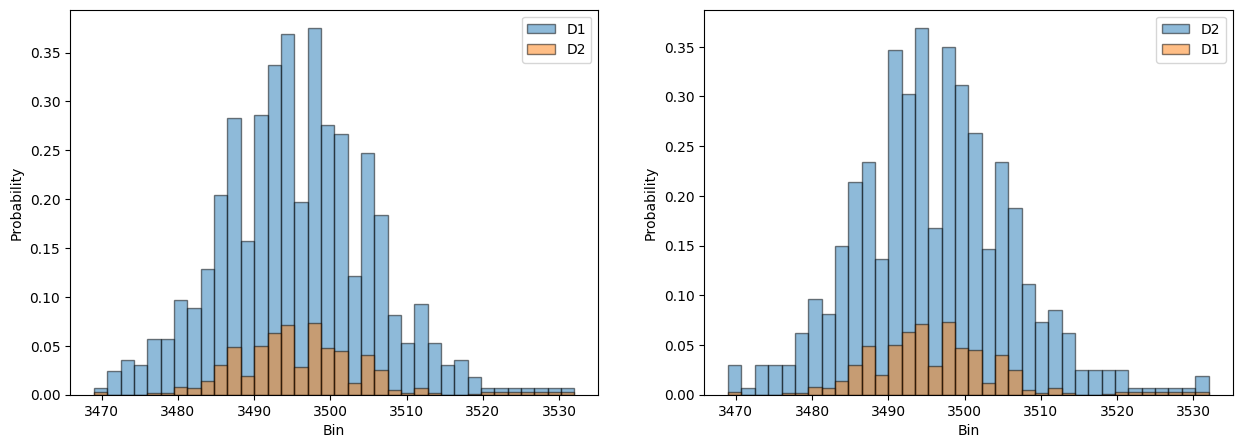

role       R1
segment     B
Name: 1, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 951 / 1000
Count of times noisy result outside bounds: 49 / 1000
Mean signed deviation:  -0.000265810746552544


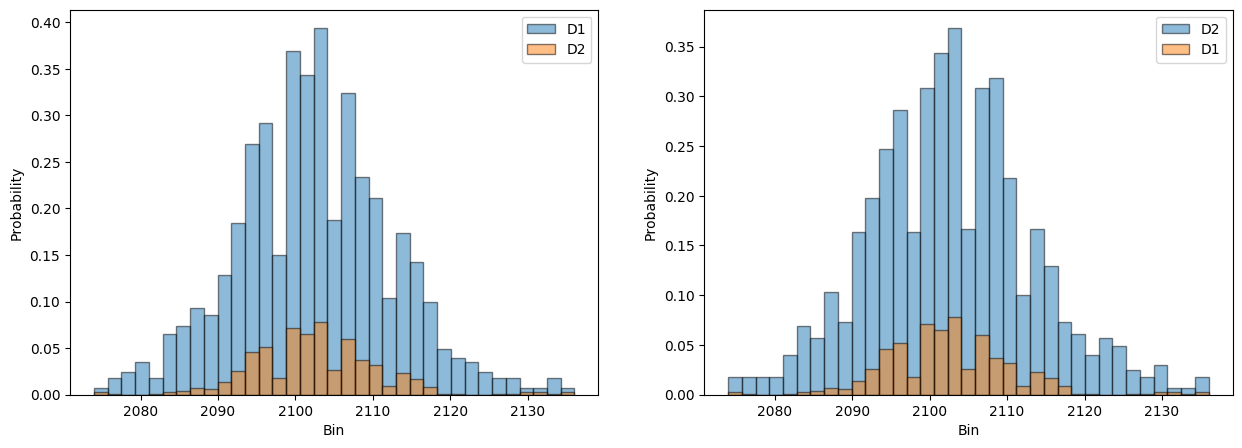

role       R1
segment     C
Name: 2, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 950 / 1000
Count of times noisy result outside bounds: 50 / 1000
Mean signed deviation:  -0.00042206896551724135


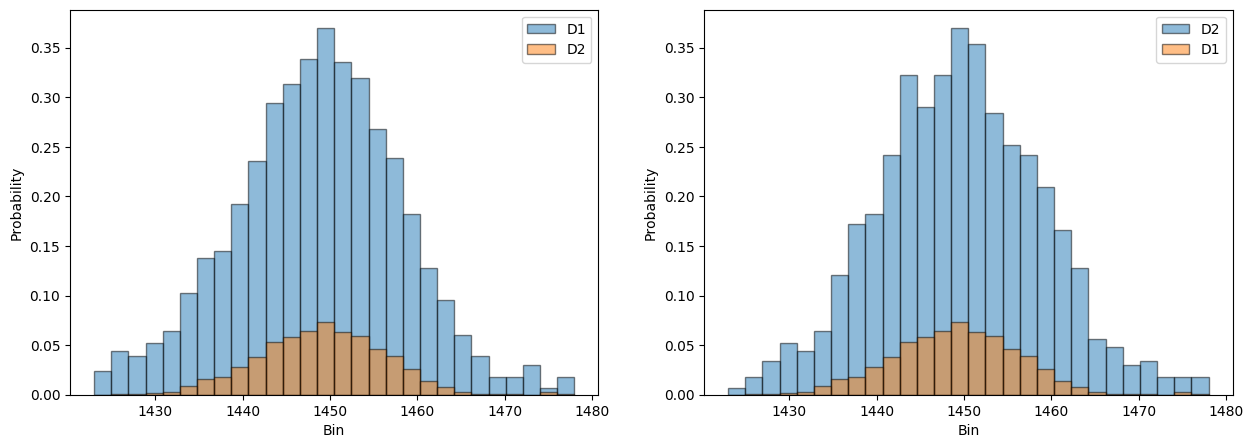

role       R2
segment     A
Name: 3, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 937 / 1000
Count of times noisy result outside bounds: 63 / 1000
Mean signed deviation:  -0.0004163090128755364


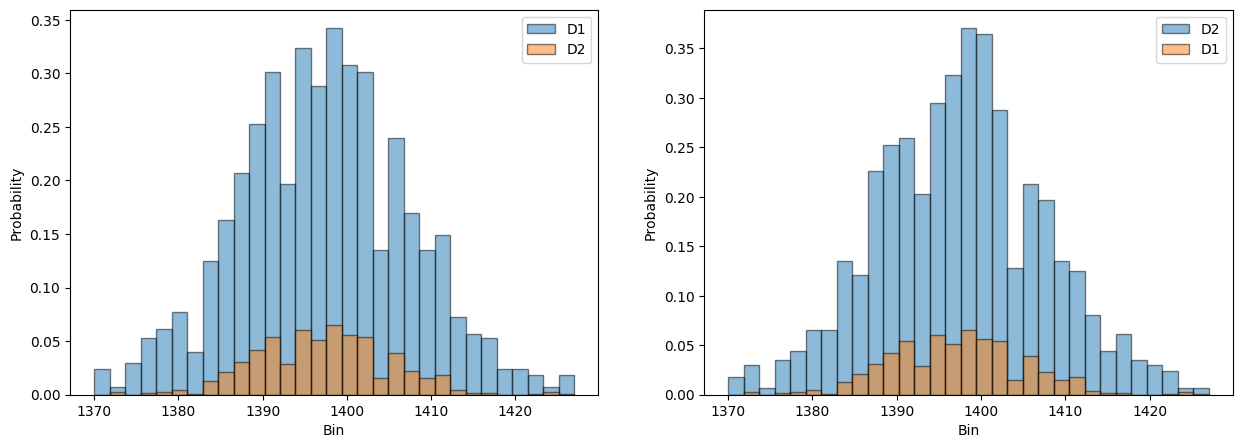

role       R2
segment     B
Name: 4, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 949 / 1000
Count of times noisy result outside bounds: 51 / 1000
Mean signed deviation:  -0.000325678496868476


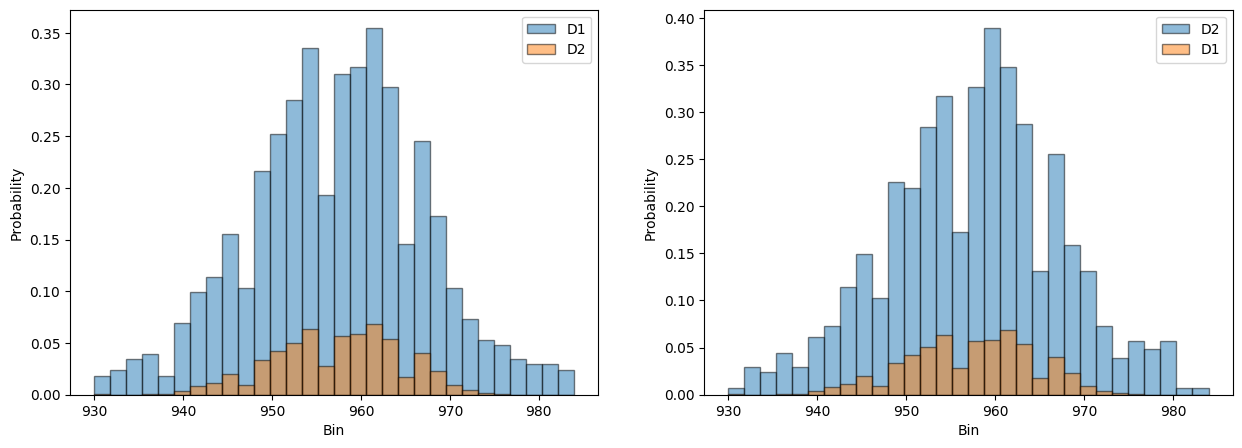

role       R2
segment     C
Name: 5, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 952 / 1000
Count of times noisy result outside bounds: 48 / 1000
Mean signed deviation:  -0.0010890756302521008


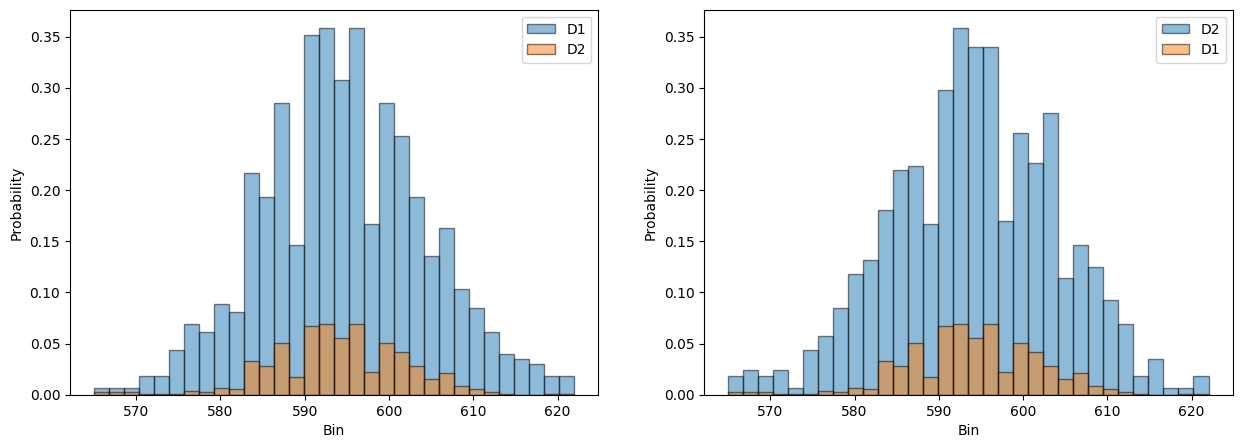

role       R1
segment     A
Name: 0, dtype: object
Column:  usage
DP Predicate Test Result:  True
Count of times noisy result within bounds: 948 / 1000
Count of times noisy result outside bounds: 52 / 1000
Mean signed deviation:  -0.0009787203858703363


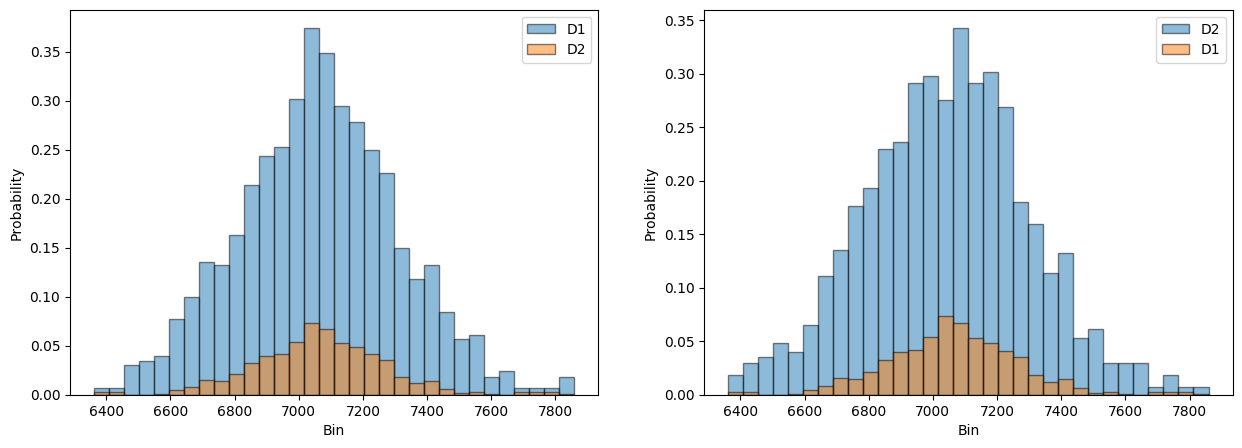

role       R1
segment     B
Name: 1, dtype: object
Column:  usage
DP Predicate Test Result:  True
Count of times noisy result within bounds: 948 / 1000
Count of times noisy result outside bounds: 52 / 1000
Mean signed deviation:  -0.0004357056694813028


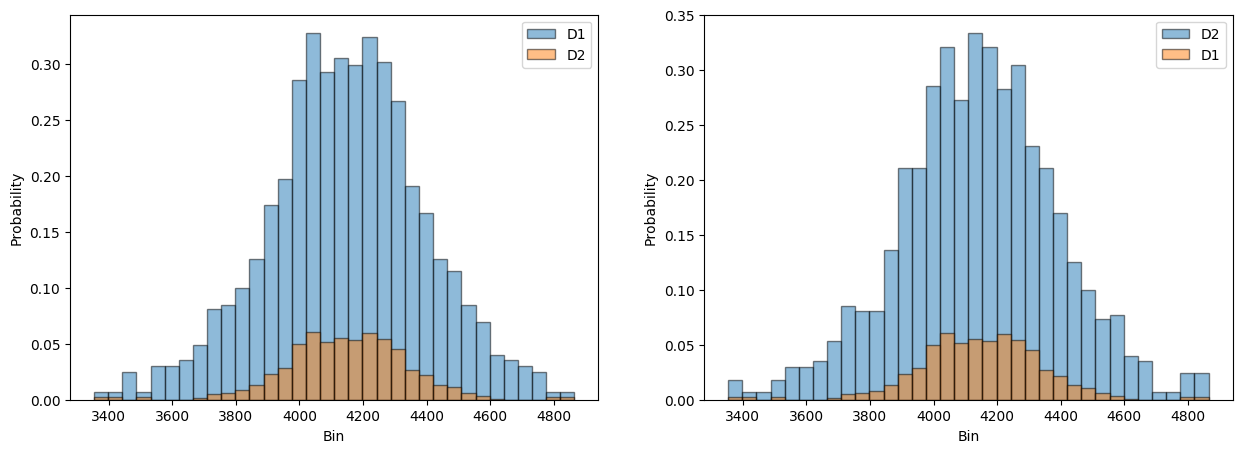

role       R1
segment     C
Name: 2, dtype: object
Column:  usage
DP Predicate Test Result:  True
Count of times noisy result within bounds: 964 / 1000
Count of times noisy result outside bounds: 36 / 1000
Mean signed deviation:  -0.0008714094856379426


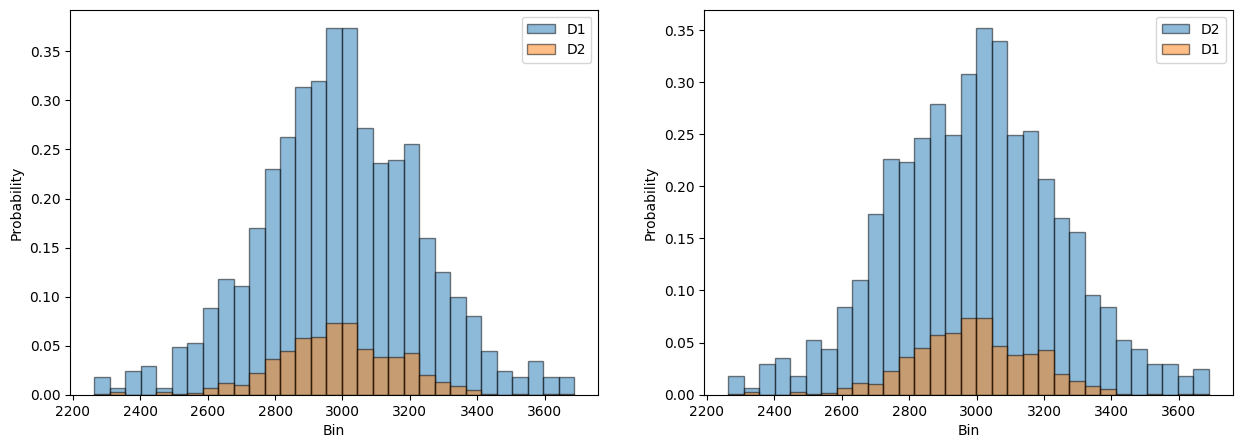

role       R2
segment     A
Name: 3, dtype: object
Column:  usage
DP Predicate Test Result:  True
Count of times noisy result within bounds: 947 / 1000
Count of times noisy result outside bounds: 53 / 1000
Mean signed deviation:  -0.004437182280319535


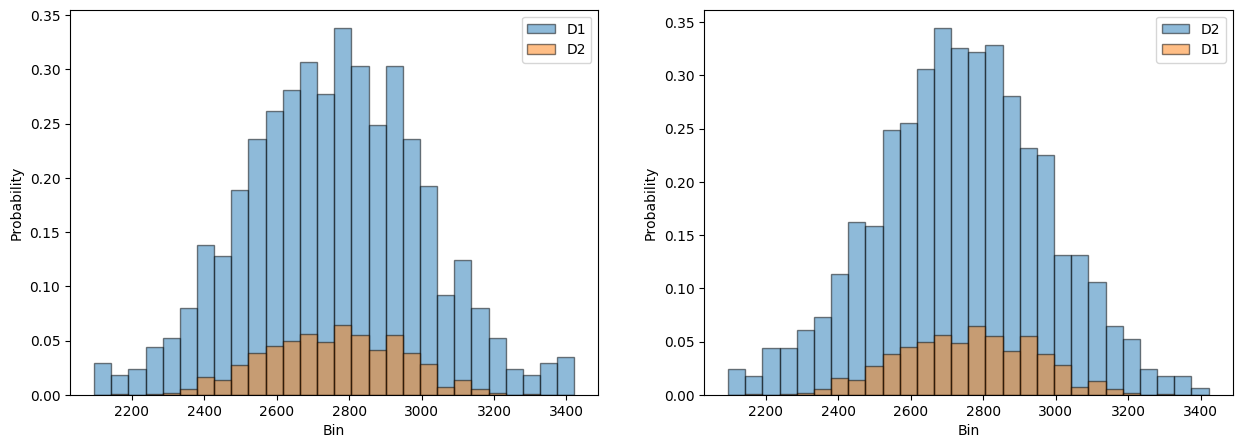

role       R2
segment     B
Name: 4, dtype: object
Column:  usage
DP Predicate Test Result:  True
Count of times noisy result within bounds: 947 / 1000
Count of times noisy result outside bounds: 53 / 1000
Mean signed deviation:  -0.0025650319829424307


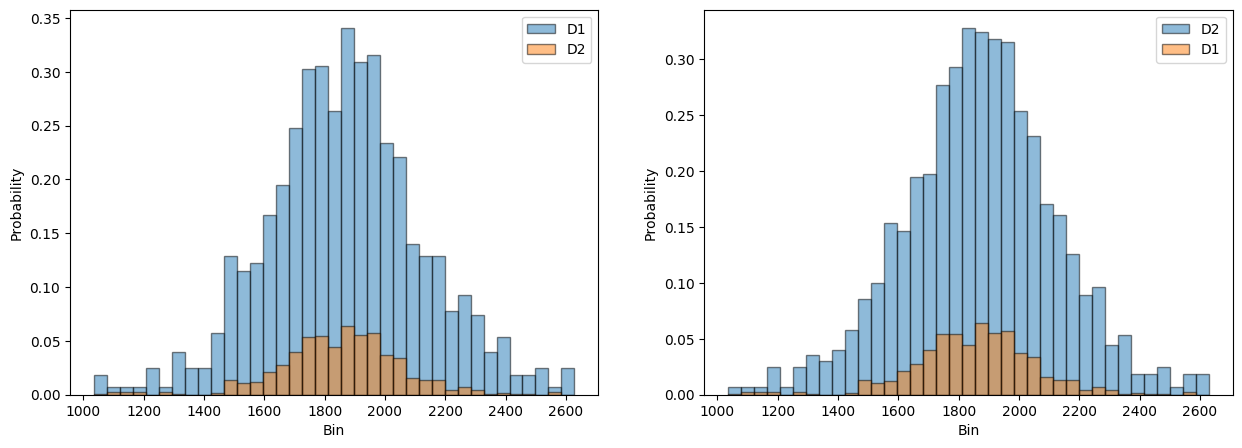

role       R2
segment     C
Name: 5, dtype: object
Column:  usage
DP Predicate Test Result:  True
Count of times noisy result within bounds: 942 / 1000
Count of times noisy result outside bounds: 58 / 1000
Mean signed deviation:  -0.007656903765690377


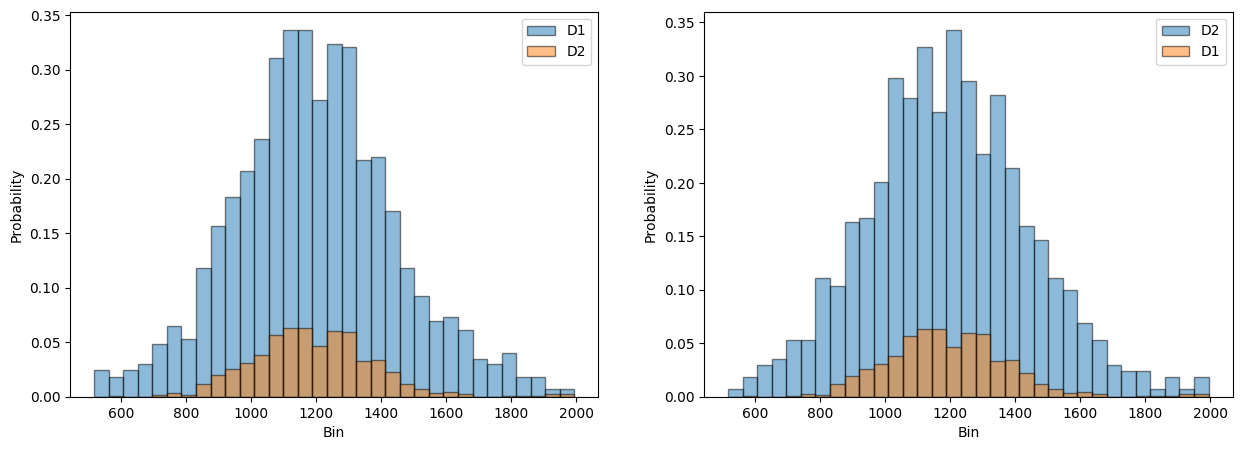

[True, True, True, 95.6, True, -0.0001375858123569794]
[True, True, True, 95.1, True, -0.000265810746552544]
[True, True, True, 95.0, True, -0.00042206896551724135]
[True, True, True, 93.7, True, -0.0004163090128755364]
[True, True, True, 94.9, True, -0.000325678496868476]
[True, True, True, 95.2, True, -0.0010890756302521008]
[True, True, True, 94.8, True, -0.0009787203858703363]
[True, True, True, 94.8, True, -0.0004357056694813028]
[True, True, True, 96.4, True, -0.0008714094856379426]
[True, True, True, 94.7, True, -0.004437182280319535]
[True, True, True, 94.7, True, -0.0025650319829424307]
[True, True, True, 94.2, True, -0.007656903765690377]
DP Predicate Test:  True
Accuracy Test:  True
Utility Test:  True
Bias Test:  True
--- 29.27270245552063 seconds ---


In [25]:
start_time = time.time()
d1_query = "SELECT Role, Segment, COUNT(UserId) AS UserCount, SUM(Usage) AS Usage FROM d1.d1 GROUP BY Role, Segment"
d2_query = "SELECT Role, Segment, COUNT(UserId) AS UserCount, SUM(Usage) AS Usage FROM d2.d2 GROUP BY Role, Segment"
dp_res, acc_res, utility_res, bias_res = dv.dp_groupby_query_test(d1_query, d2_query, plot=True, repeat_count=1000, exact=False)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
__dim__    key
Name: 0, dtype: object
Column:  usercount
DP Predicate Test Result:  True
Count of times noisy result within bounds: 950 / 1000
Count of times noisy result outside bounds: 50 / 1000
Mean signed deviation:  -8.120000000000001e-05


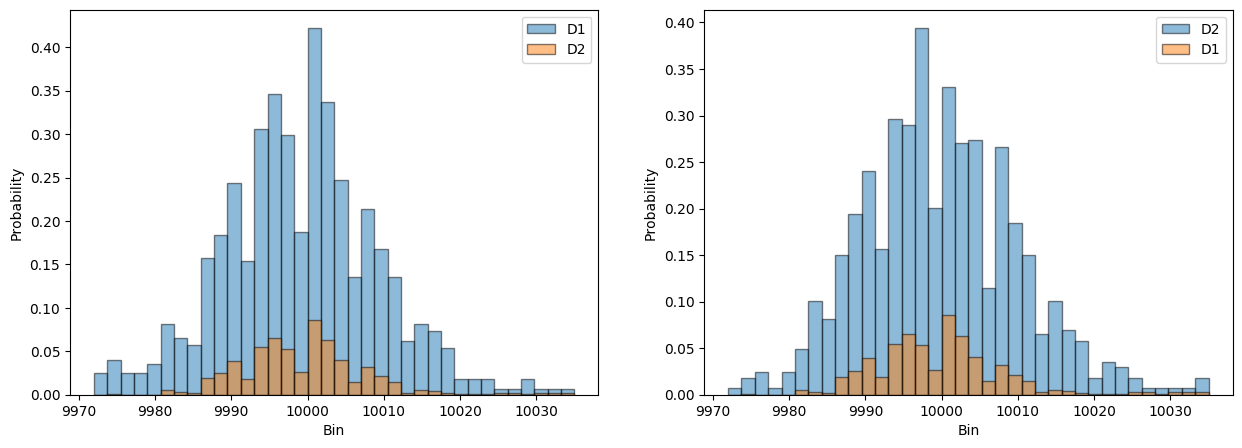

[True, True, True, 95.0, True, -8.120000000000001e-05]
DP Predicate Test:  True
Accuracy Test:  True
Utility Test:  True
Bias Test:  True
--- 7.957890510559082 seconds ---


In [26]:
start_time = time.time()
d1_query = "SELECT COUNT(UserId) AS UserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS UserCount FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_groupby_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### Powerset Test

Test case:  [0.0, -333.33333333333337, -600.0]
Testing:  012_0
Count of times noisy result within bounds: 471 / 500
Count of times noisy result outside bounds: 29 / 500
Mean signed deviation:  0.5910494619640473
DP Predicate Test Result:  True


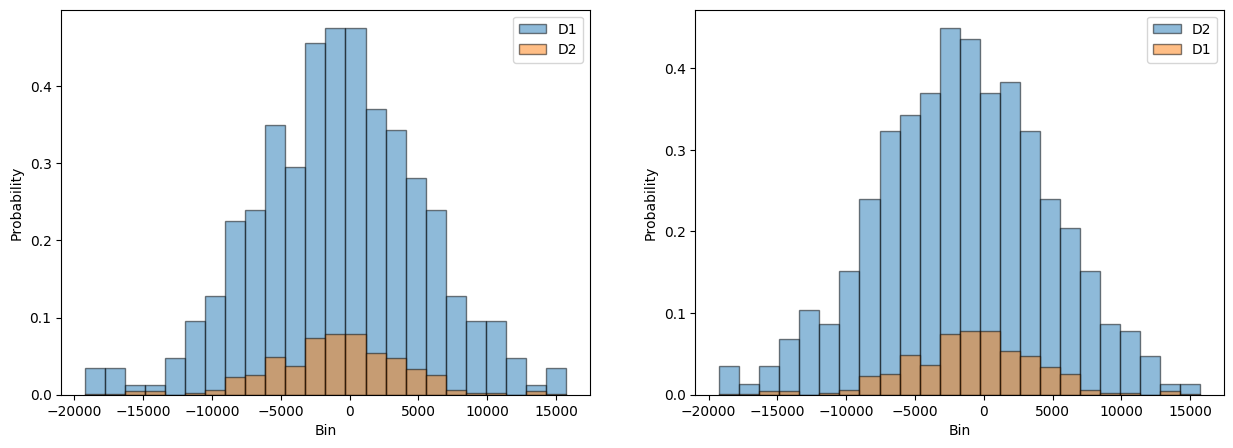

Testing:  12_1
Count of times noisy result within bounds: 481 / 500
Count of times noisy result outside bounds: 19 / 500
Mean signed deviation:  0.21613891802300633
DP Predicate Test Result:  True


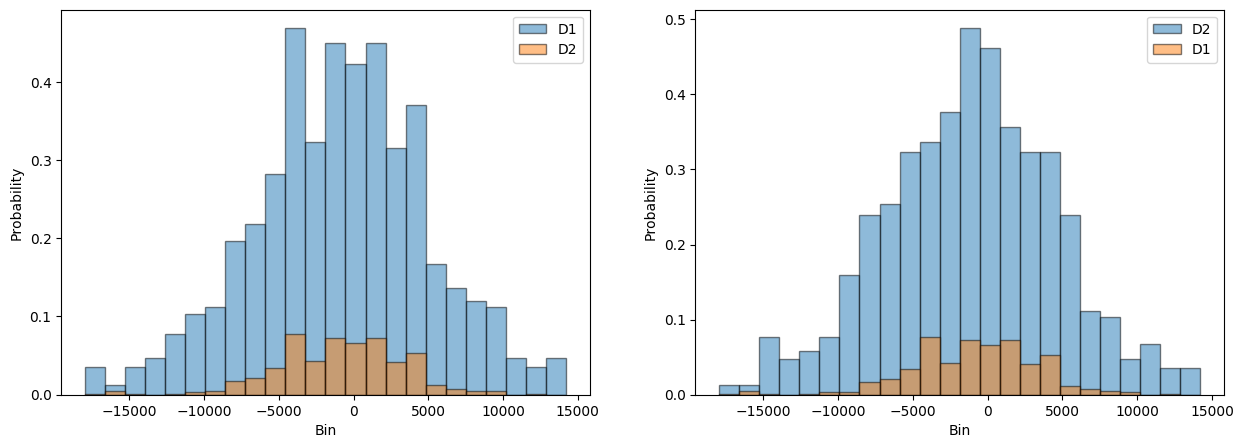

Testing:  2_2
Count of times noisy result within bounds: 470 / 500
Count of times noisy result outside bounds: 30 / 500
Mean signed deviation:  -0.7156634202357375
DP Predicate Test Result:  True


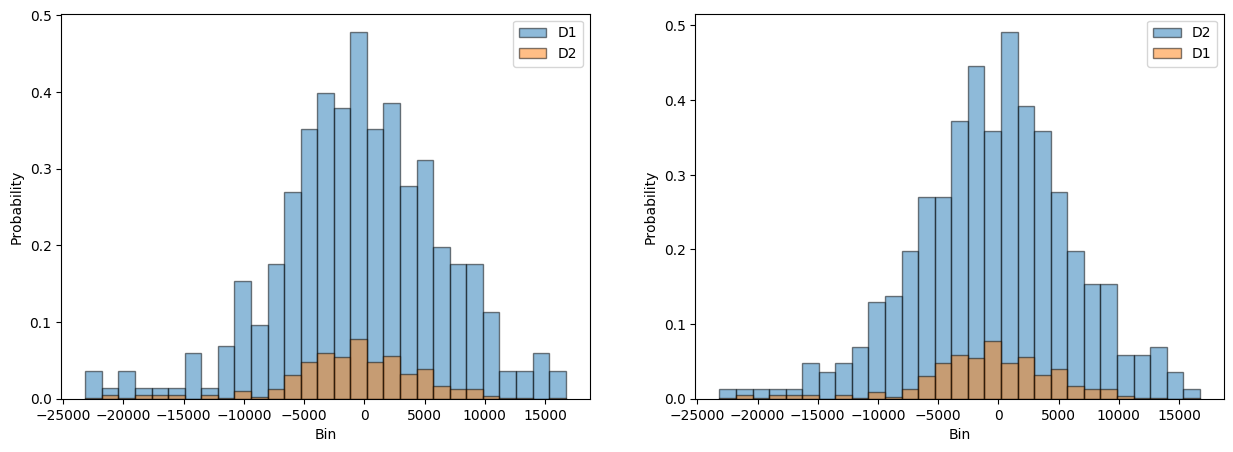

Testing:  12_2
Count of times noisy result within bounds: 470 / 500
Count of times noisy result outside bounds: 30 / 500
Mean signed deviation:  0.2258127463947124
DP Predicate Test Result:  True


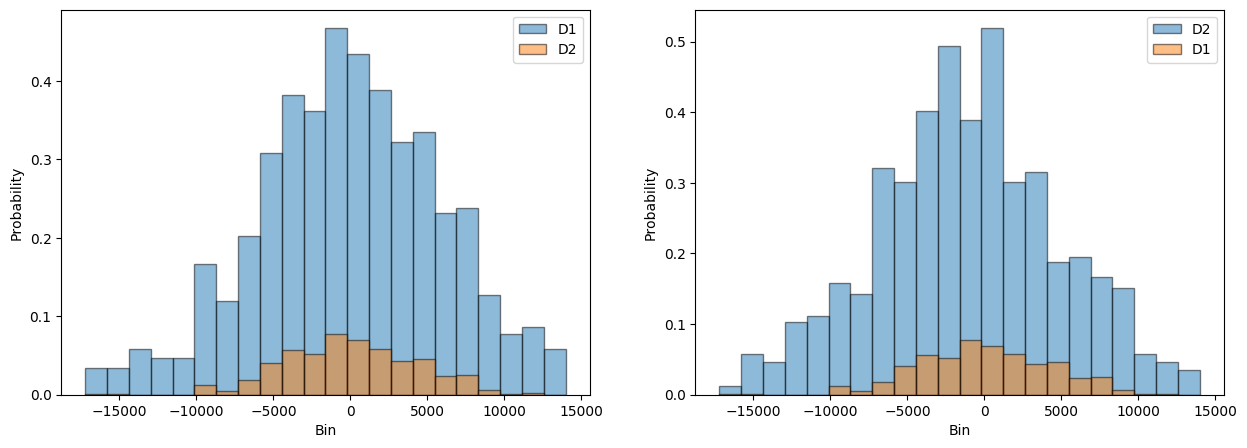

Testing:  1_1
Count of times noisy result within bounds: 472 / 500
Count of times noisy result outside bounds: 28 / 500
Mean signed deviation:  -0.9602676150152595
DP Predicate Test Result:  True


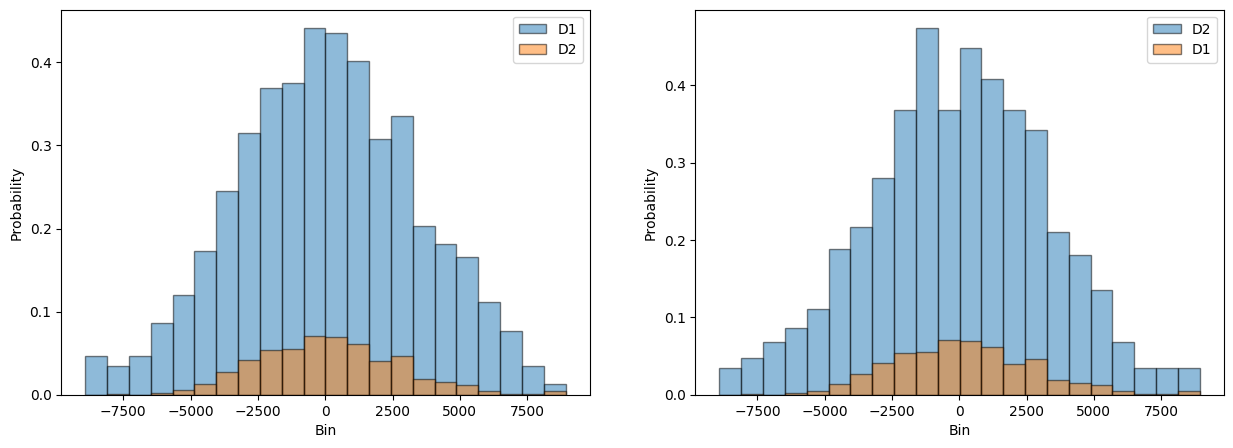

Testing:  012_1
Count of times noisy result within bounds: 469 / 500
Count of times noisy result outside bounds: 31 / 500
Mean signed deviation:  0.2874221484068832
DP Predicate Test Result:  True


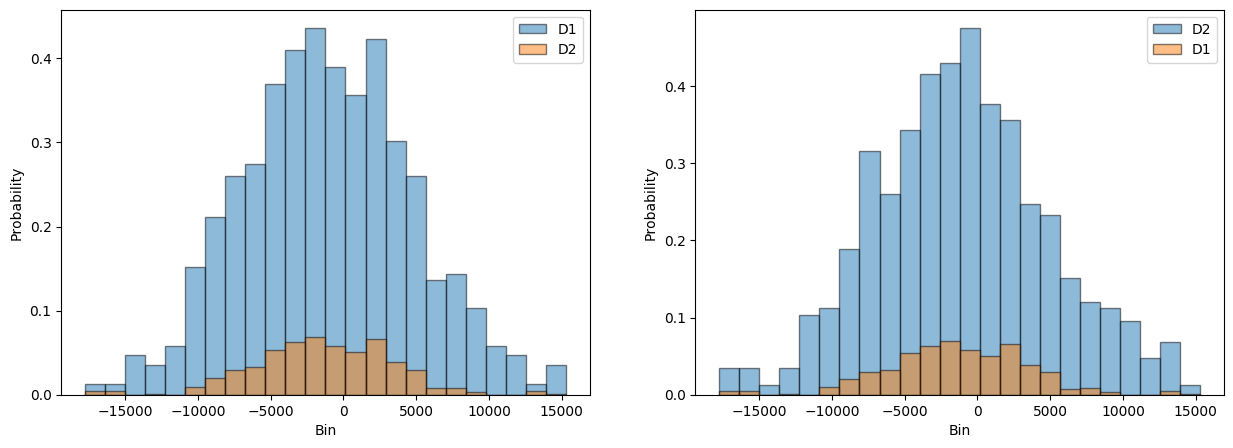

Testing:  02_0
Count of times noisy result within bounds: 471 / 500
Count of times noisy result outside bounds: 29 / 500
Mean signed deviation:  -0.5136574590878092
DP Predicate Test Result:  True


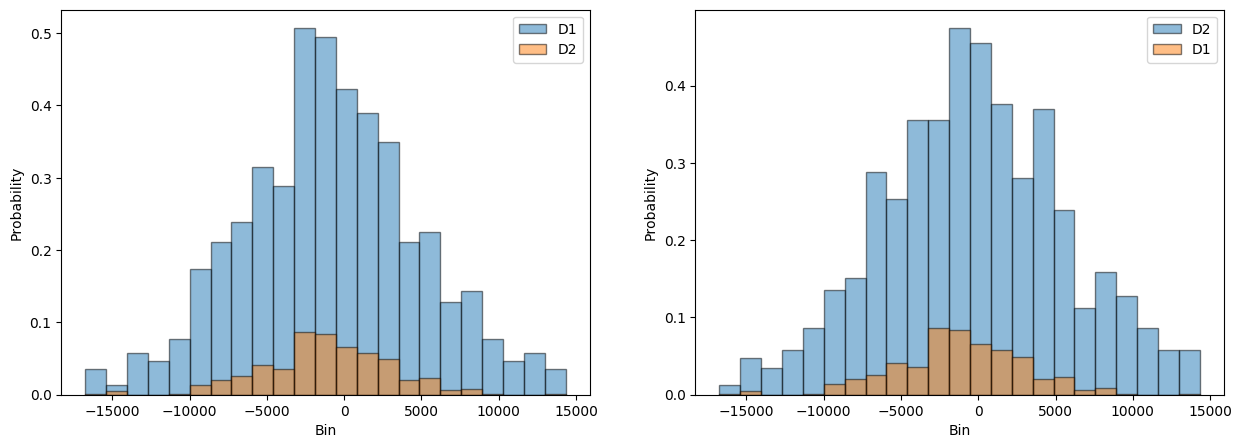

Testing:  02_2
Count of times noisy result within bounds: 471 / 500
Count of times noisy result outside bounds: 29 / 500
Mean signed deviation:  0.11933106163996281
DP Predicate Test Result:  True


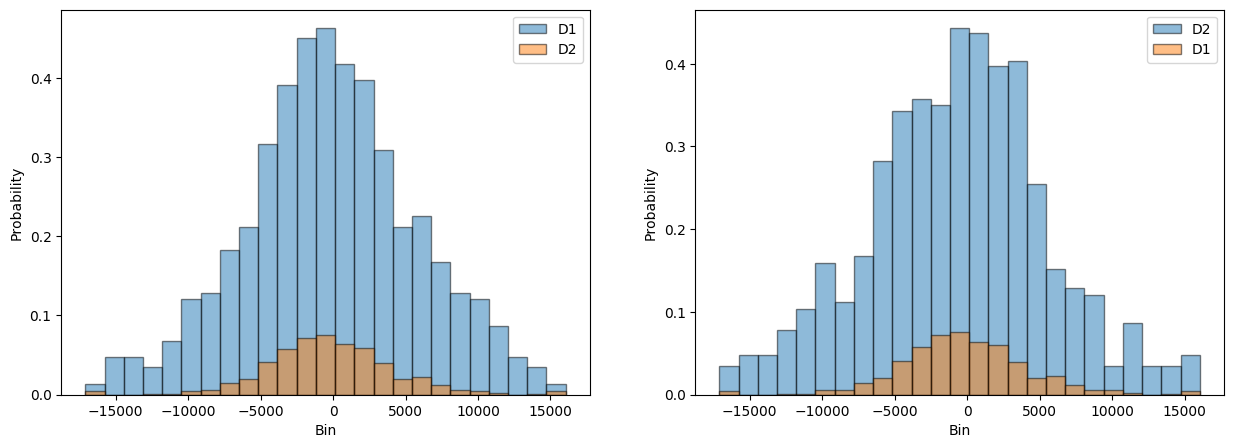

Testing:  0_0
Count of times noisy result within bounds: 0 / 500
Count of times noisy result outside bounds: 500 / 500
Mean signed deviation:  nan
DP Predicate Test Result:  True


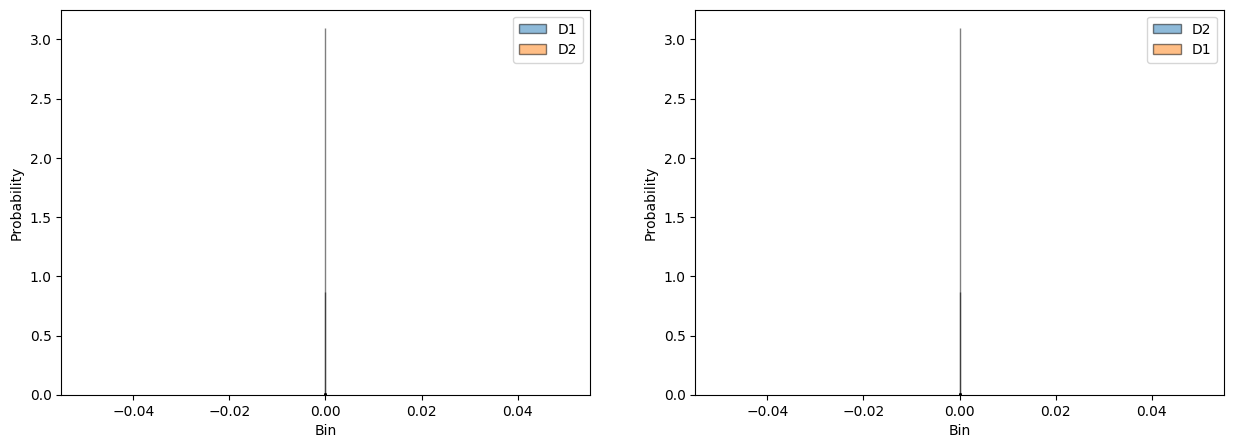

Testing:  012_2
Count of times noisy result within bounds: 475 / 500
Count of times noisy result outside bounds: 25 / 500
Mean signed deviation:  0.007957423463514258
DP Predicate Test Result:  True


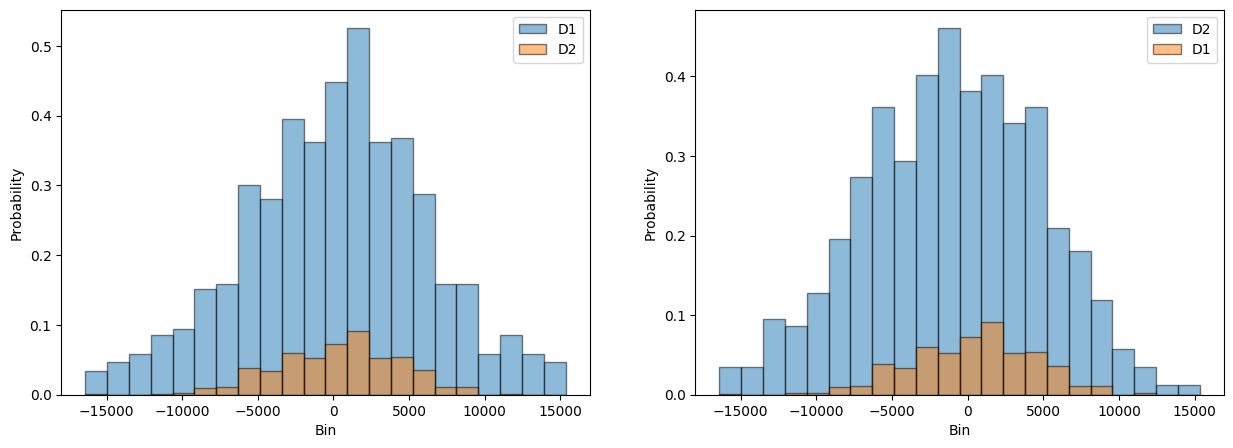

Testing:  01_0
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  0.4543341177839746
DP Predicate Test Result:  True


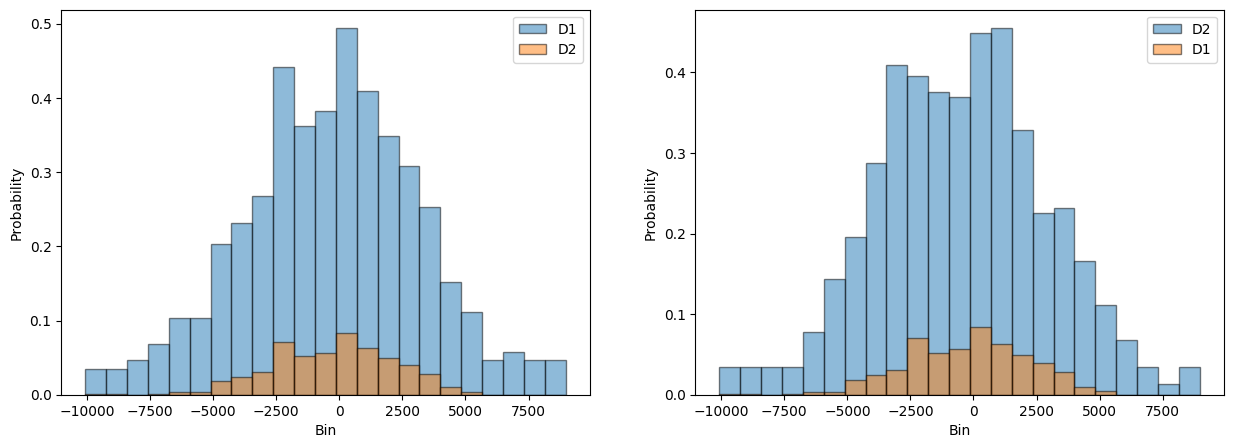

Testing:  01_1
Count of times noisy result within bounds: 472 / 500
Count of times noisy result outside bounds: 28 / 500
Mean signed deviation:  -0.41416291036948316
DP Predicate Test Result:  True


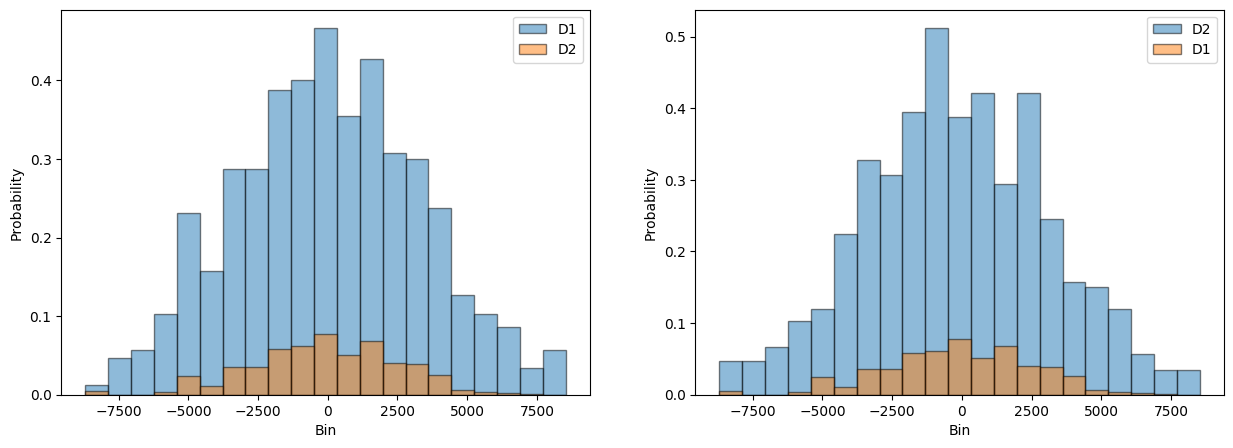

Test case:  [-500.0, 333.33333333333326, -200.0]
Testing:  012_0
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  -0.17469772339158776
DP Predicate Test Result:  True


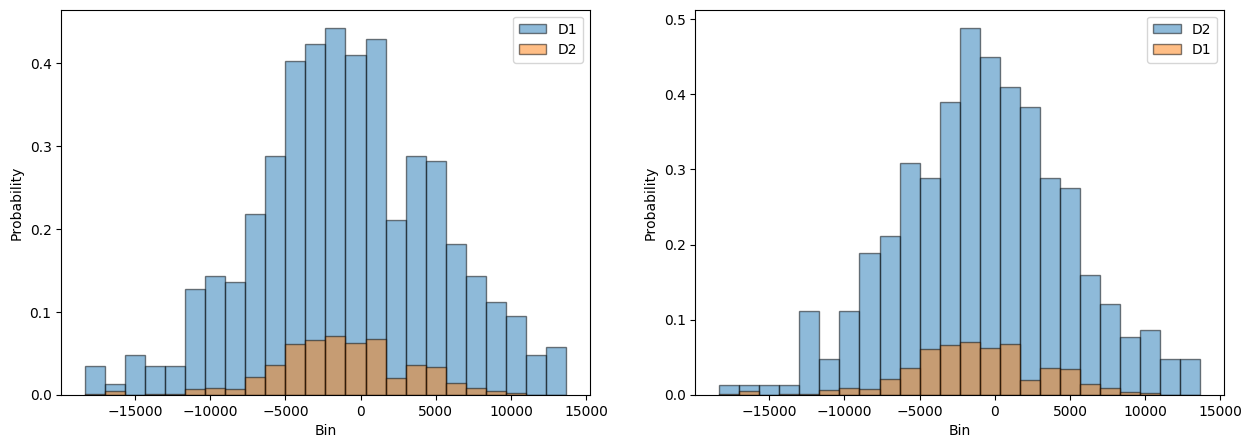

Testing:  12_1
Count of times noisy result within bounds: 476 / 500
Count of times noisy result outside bounds: 24 / 500
Mean signed deviation:  -0.0511788808786715
DP Predicate Test Result:  True


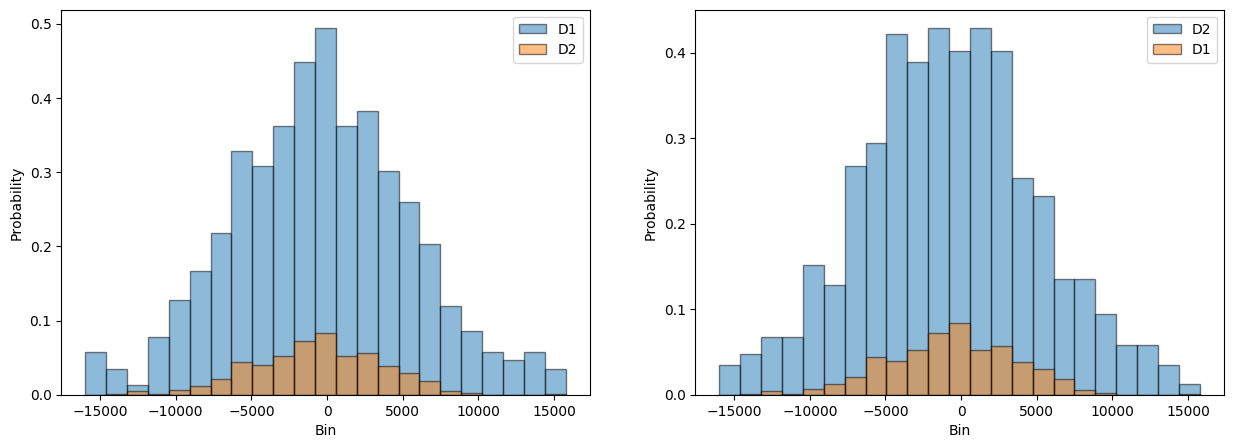

Testing:  2_2
Count of times noisy result within bounds: 469 / 500
Count of times noisy result outside bounds: 31 / 500
Mean signed deviation:  -0.8209221847573429
DP Predicate Test Result:  True


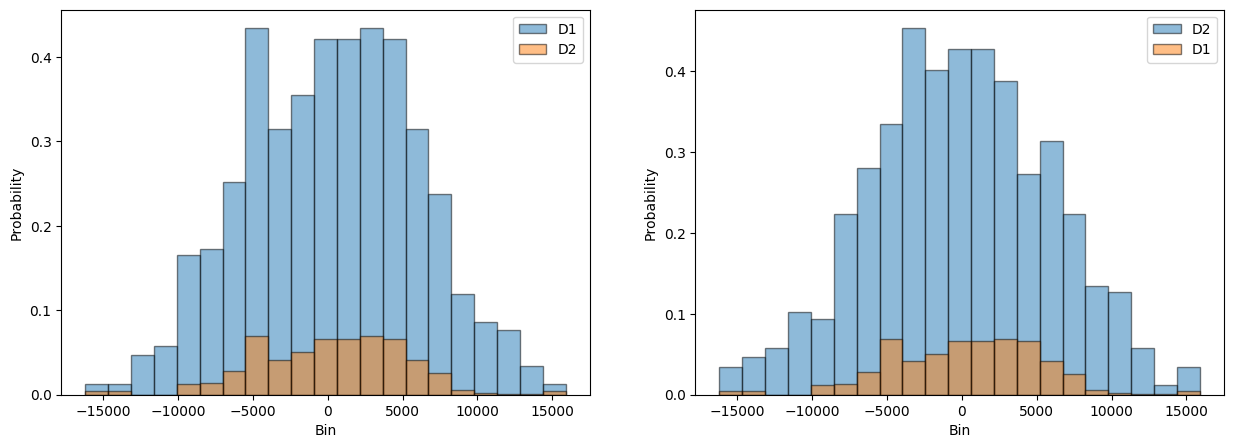

Testing:  12_2
Count of times noisy result within bounds: 475 / 500
Count of times noisy result outside bounds: 25 / 500
Mean signed deviation:  0.0302242723283911
DP Predicate Test Result:  True


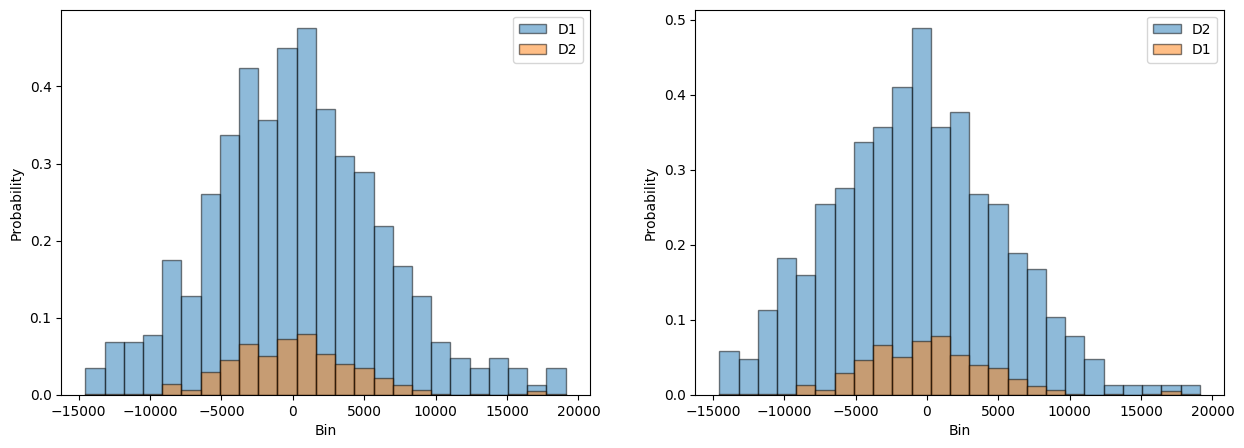

Testing:  1_1
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  -1.3850401023998358
DP Predicate Test Result:  True


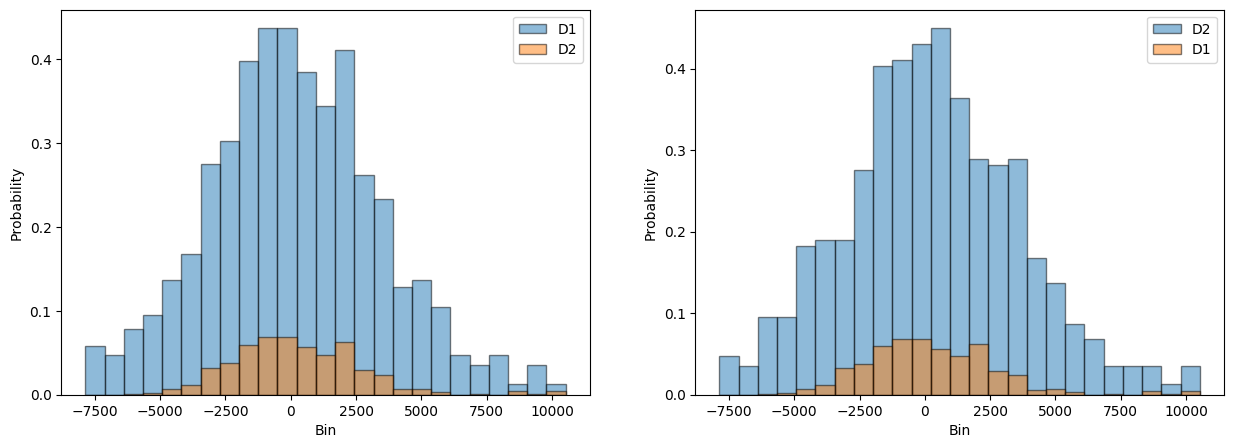

Testing:  012_1
Count of times noisy result within bounds: 480 / 500
Count of times noisy result outside bounds: 20 / 500
Mean signed deviation:  -0.4648501797408491
DP Predicate Test Result:  True


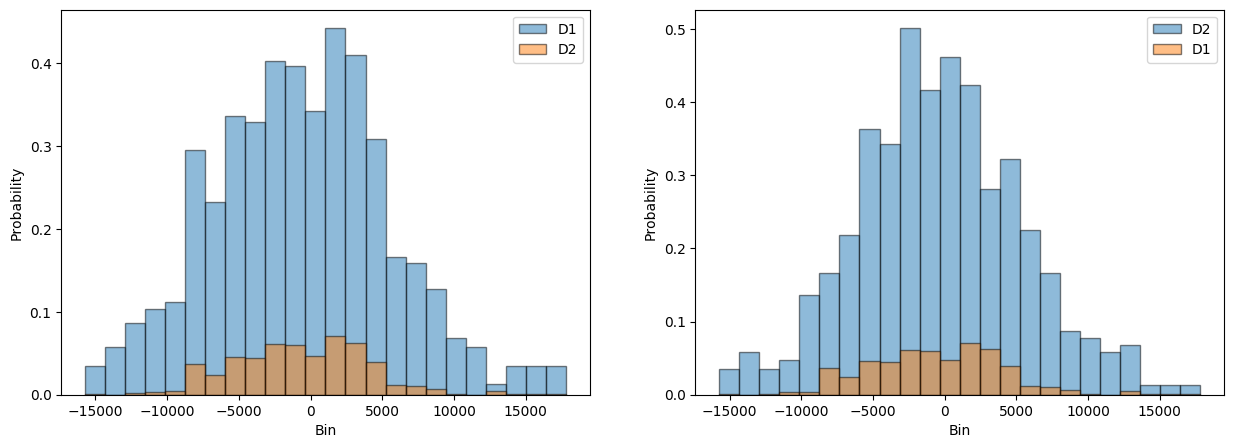

Testing:  02_0
Count of times noisy result within bounds: 483 / 500
Count of times noisy result outside bounds: 17 / 500
Mean signed deviation:  -0.4821660901453666
DP Predicate Test Result:  True


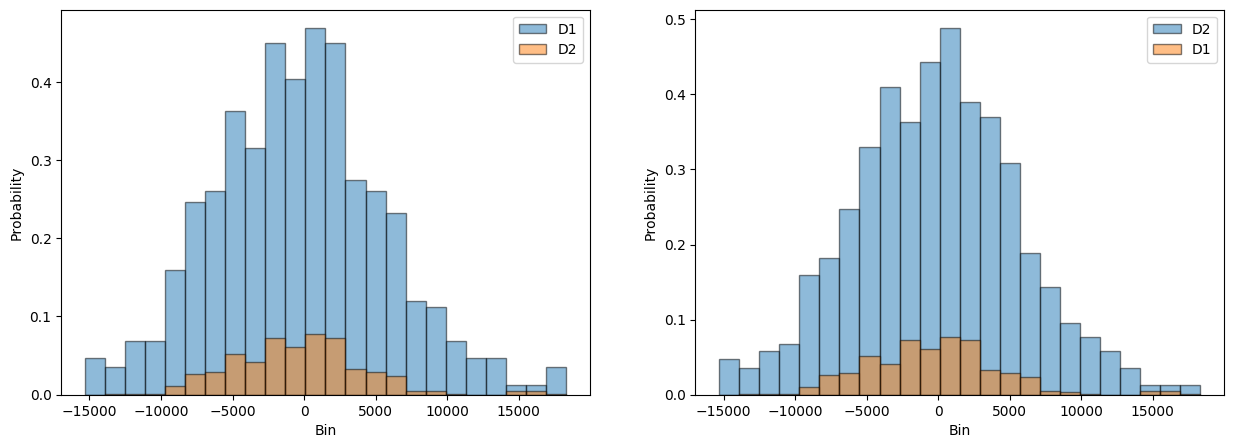

Testing:  02_2
Count of times noisy result within bounds: 472 / 500
Count of times noisy result outside bounds: 28 / 500
Mean signed deviation:  0.20782707543633358
DP Predicate Test Result:  True


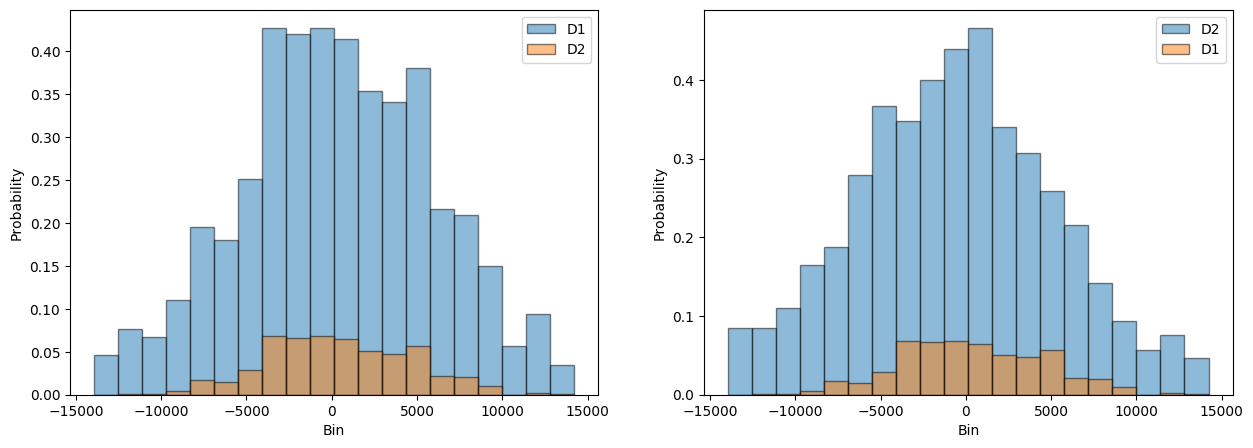

Testing:  0_0
Count of times noisy result within bounds: 0 / 500
Count of times noisy result outside bounds: 500 / 500
Mean signed deviation:  nan
DP Predicate Test Result:  True


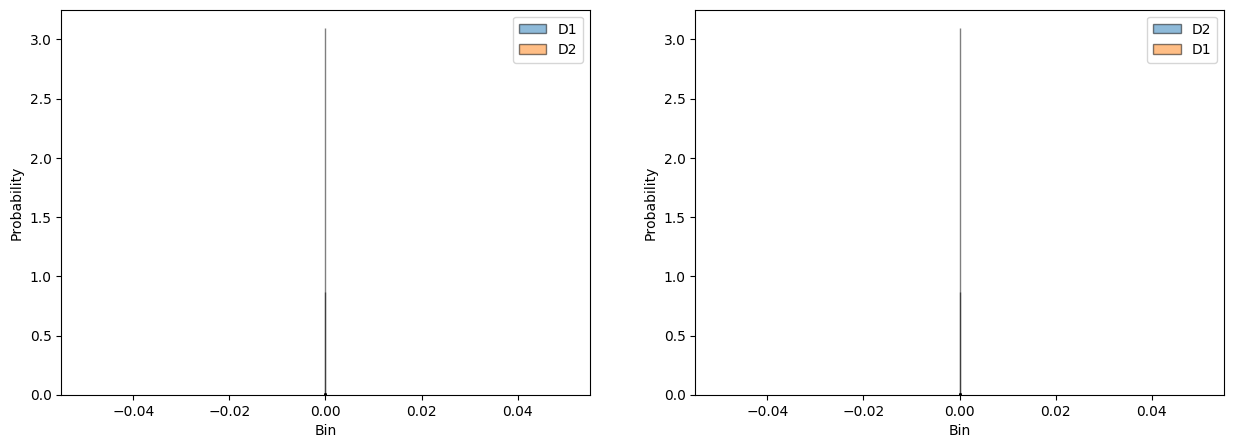

Testing:  012_2
Count of times noisy result within bounds: 473 / 500
Count of times noisy result outside bounds: 27 / 500
Mean signed deviation:  -0.2806391121537624
DP Predicate Test Result:  True


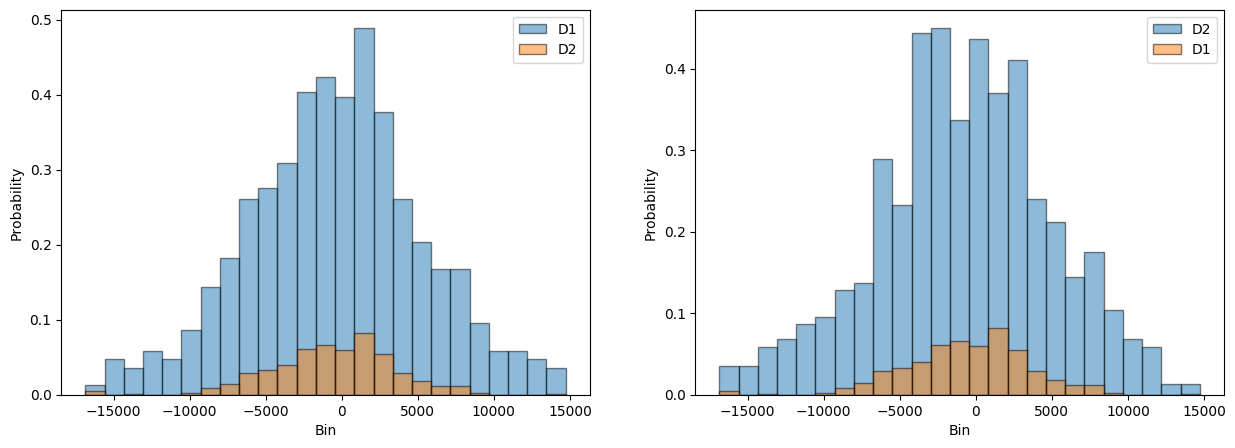

Testing:  01_0
Count of times noisy result within bounds: 469 / 500
Count of times noisy result outside bounds: 31 / 500
Mean signed deviation:  -0.3523323122642775
DP Predicate Test Result:  True


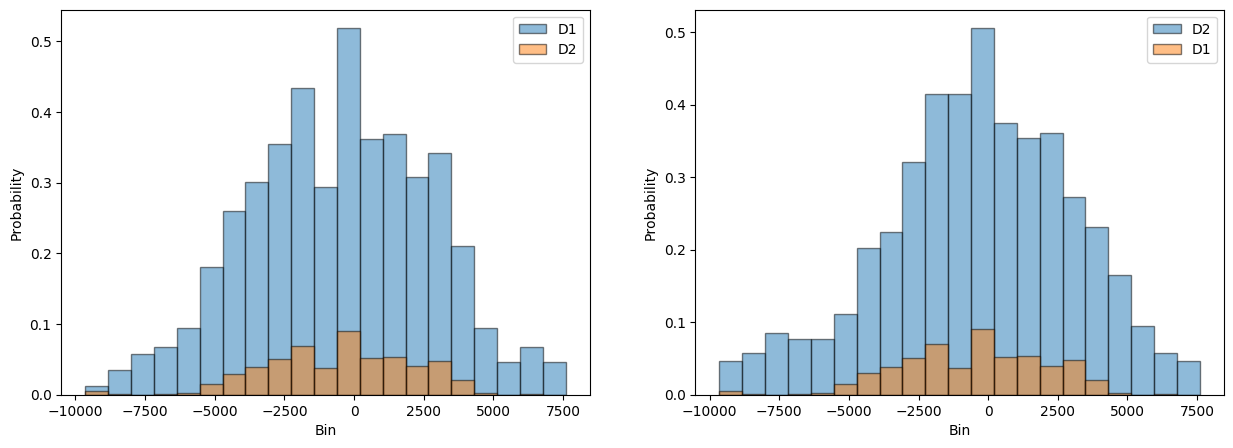

Testing:  01_1
Count of times noisy result within bounds: 477 / 500
Count of times noisy result outside bounds: 23 / 500
Mean signed deviation:  -0.6444299609122687
DP Predicate Test Result:  True


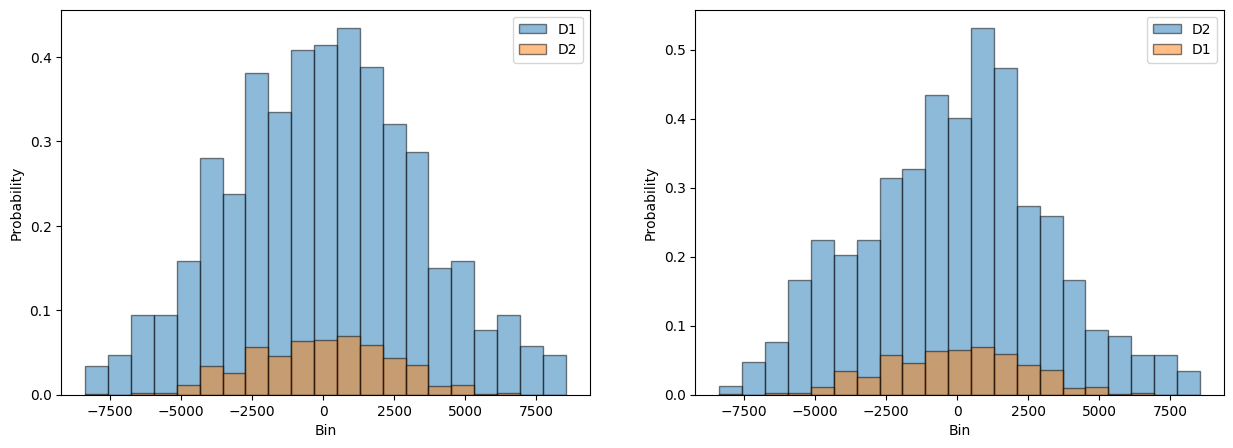

Test case:  [500.0, -777.7777777777778, 200.0]
Testing:  012_0
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  -0.24395266398334176
DP Predicate Test Result:  True


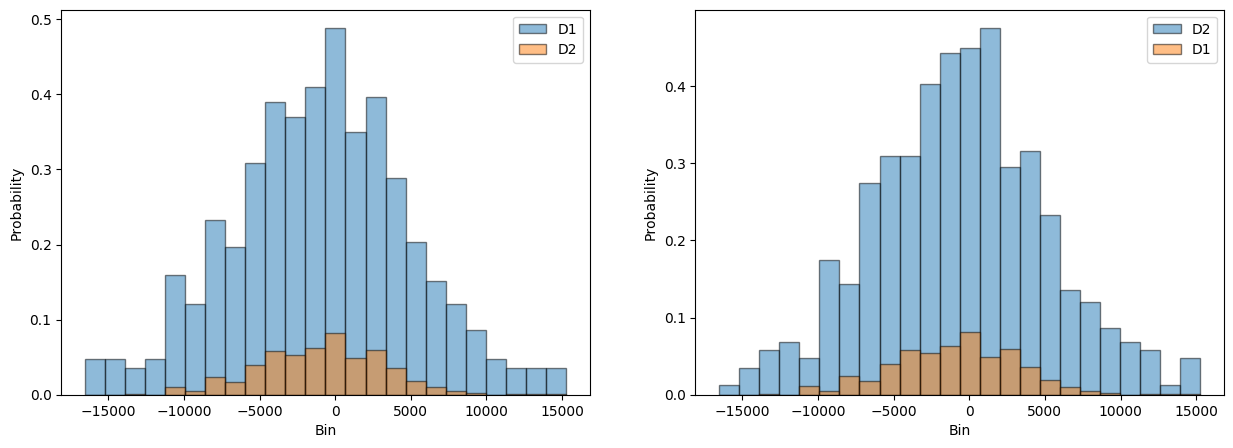

Testing:  12_1
Count of times noisy result within bounds: 482 / 500
Count of times noisy result outside bounds: 18 / 500
Mean signed deviation:  -0.27076629368117705
DP Predicate Test Result:  True


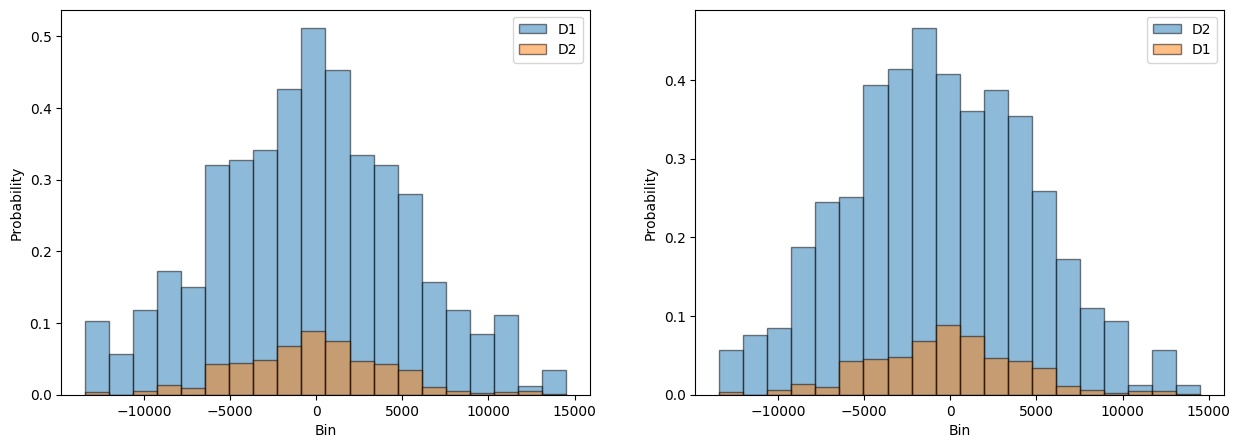

Testing:  2_2
Count of times noisy result within bounds: 470 / 500
Count of times noisy result outside bounds: 30 / 500
Mean signed deviation:  -1.2464221817993348
DP Predicate Test Result:  True


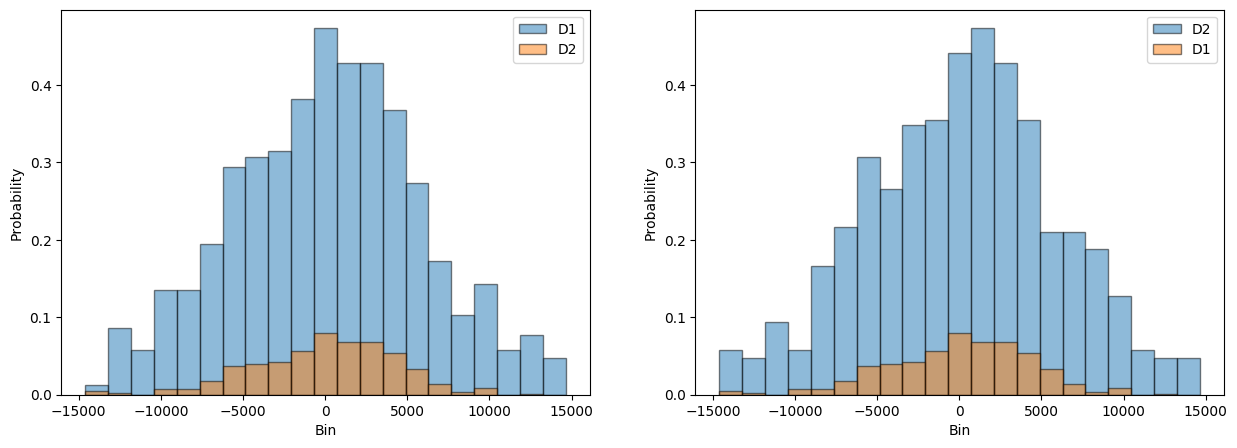

Testing:  12_2
Count of times noisy result within bounds: 469 / 500
Count of times noisy result outside bounds: 31 / 500
Mean signed deviation:  0.16998830330394338
DP Predicate Test Result:  True


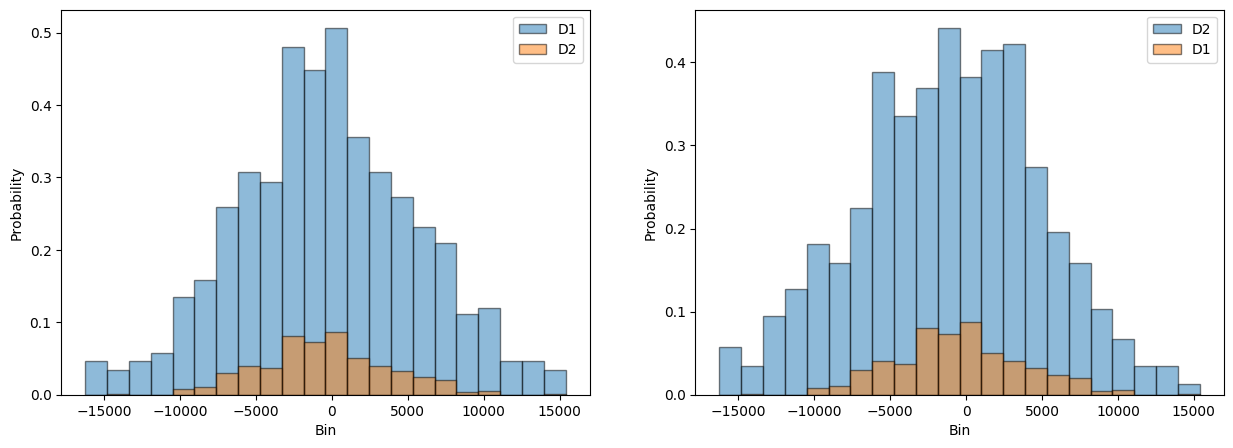

Testing:  1_1
Count of times noisy result within bounds: 470 / 500
Count of times noisy result outside bounds: 30 / 500
Mean signed deviation:  -1.3831288734107552
DP Predicate Test Result:  True


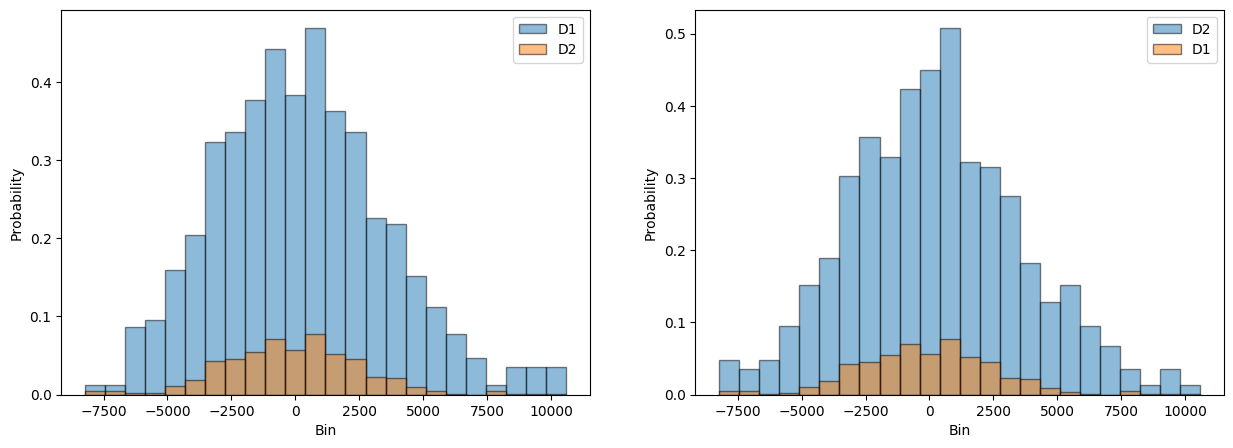

Testing:  012_1
Count of times noisy result within bounds: 476 / 500
Count of times noisy result outside bounds: 24 / 500
Mean signed deviation:  0.2933151874189099
DP Predicate Test Result:  True


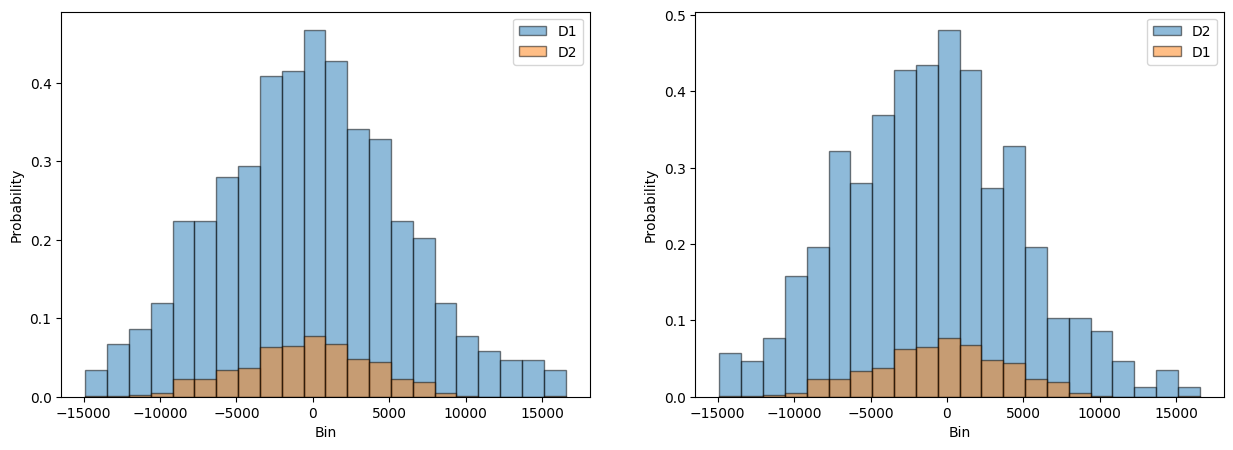

Testing:  02_0
Count of times noisy result within bounds: 476 / 500
Count of times noisy result outside bounds: 24 / 500
Mean signed deviation:  -0.00431776960168337
DP Predicate Test Result:  True


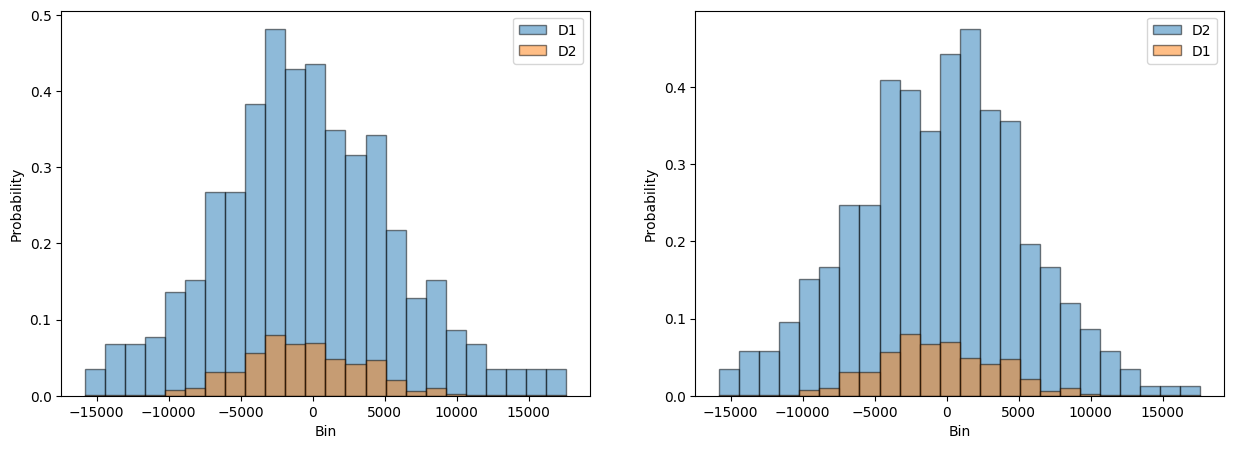

Testing:  02_2
Count of times noisy result within bounds: 471 / 500
Count of times noisy result outside bounds: 29 / 500
Mean signed deviation:  -0.07119347937150106
DP Predicate Test Result:  True


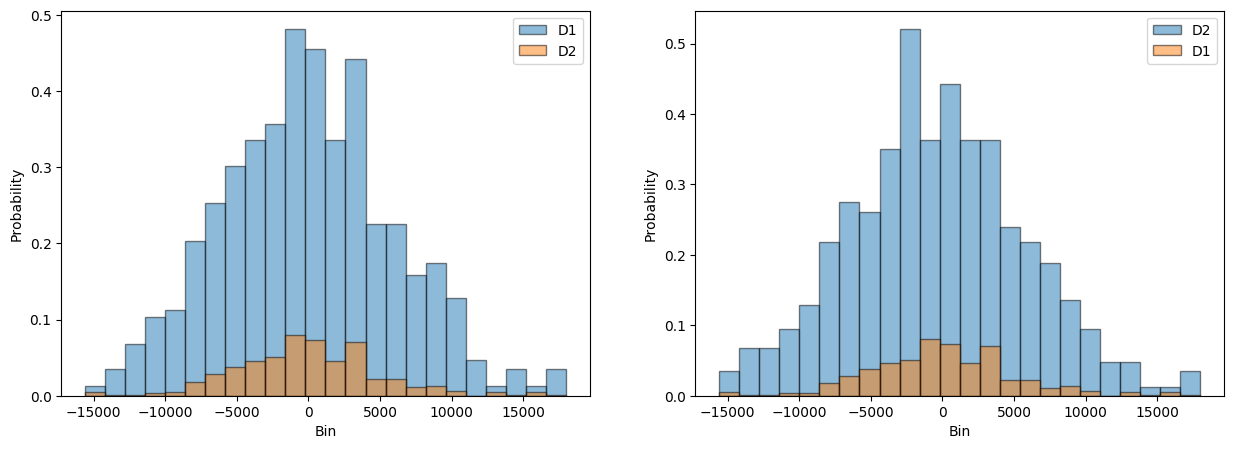

Testing:  0_0
Count of times noisy result within bounds: 0 / 500
Count of times noisy result outside bounds: 500 / 500
Mean signed deviation:  nan
DP Predicate Test Result:  True


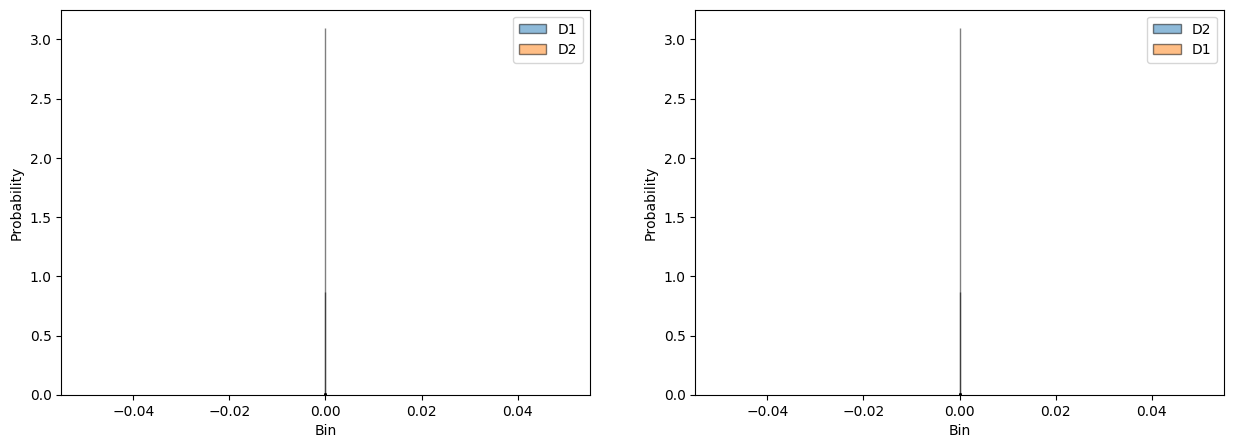

Testing:  012_2
Count of times noisy result within bounds: 480 / 500
Count of times noisy result outside bounds: 20 / 500
Mean signed deviation:  -0.20963354612738042
DP Predicate Test Result:  True


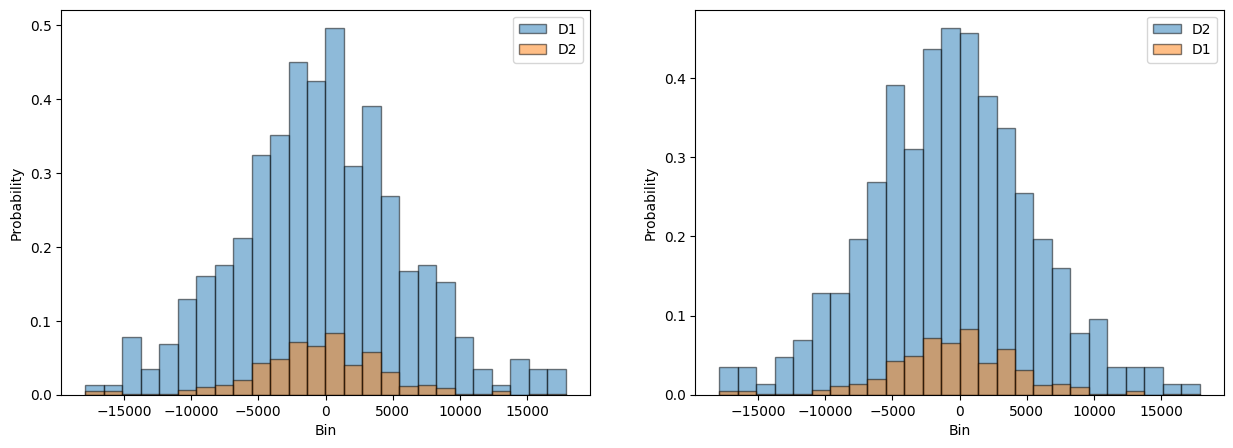

Testing:  01_0
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  0.5067809405349168
DP Predicate Test Result:  True


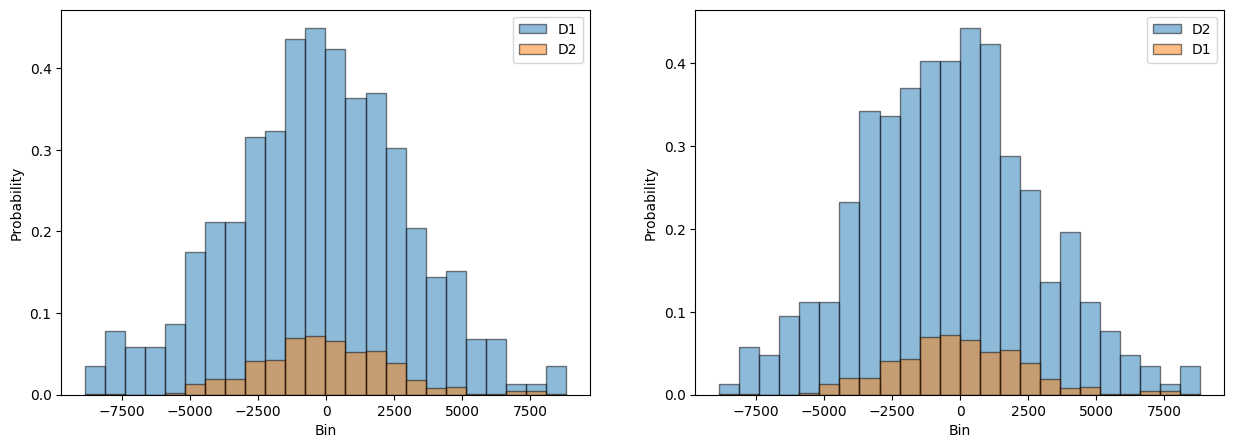

Testing:  01_1
Count of times noisy result within bounds: 473 / 500
Count of times noisy result outside bounds: 27 / 500
Mean signed deviation:  0.44603612935173803
DP Predicate Test Result:  True


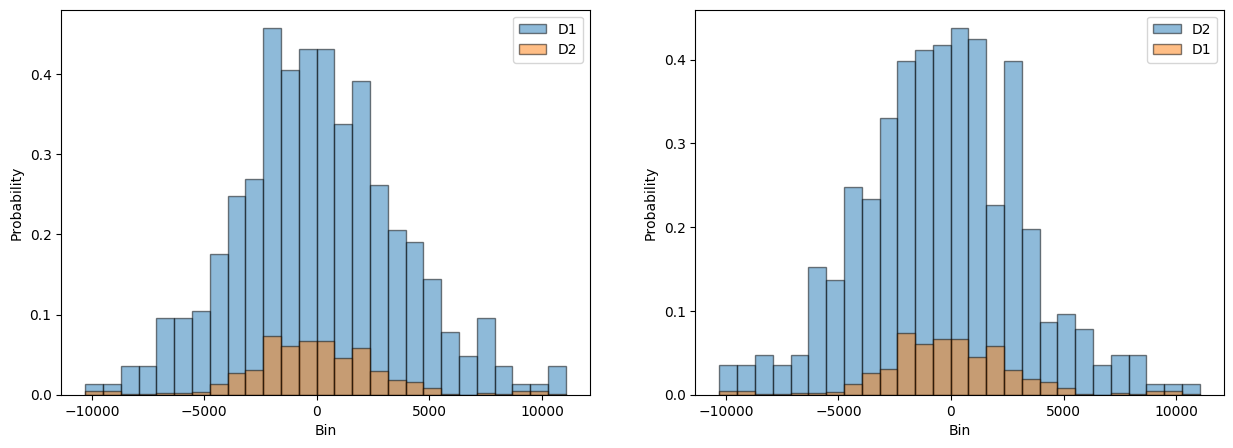

Test case:  [-750.0, -111.1111111111112, 600.0]
Testing:  012_0
Count of times noisy result within bounds: 475 / 500
Count of times noisy result outside bounds: 25 / 500
Mean signed deviation:  -0.02222343680128791
DP Predicate Test Result:  True


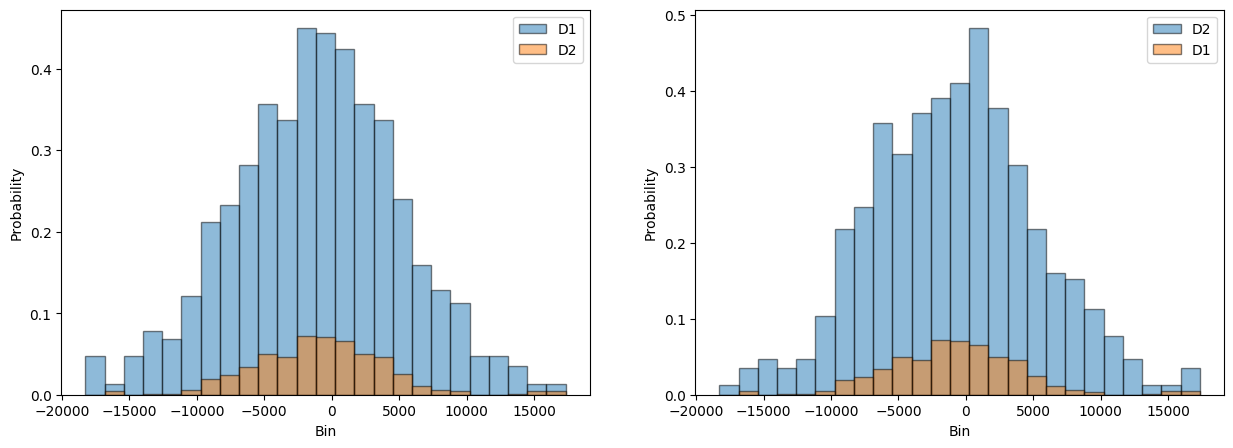

Testing:  12_1
Count of times noisy result within bounds: 462 / 500
Count of times noisy result outside bounds: 38 / 500
Mean signed deviation:  -0.19518334966552917
DP Predicate Test Result:  True


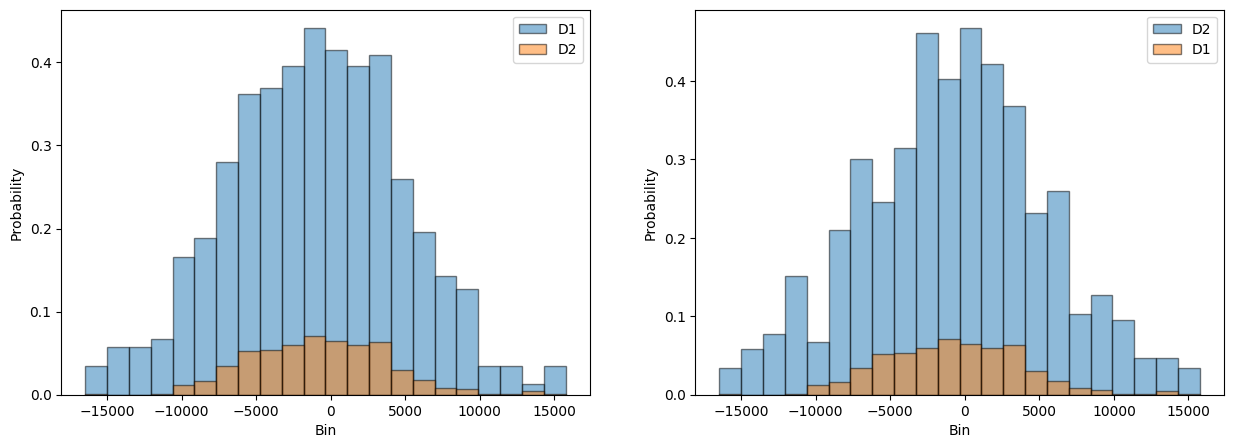

Testing:  2_2
Count of times noisy result within bounds: 474 / 500
Count of times noisy result outside bounds: 26 / 500
Mean signed deviation:  -0.8429486044998341
DP Predicate Test Result:  True


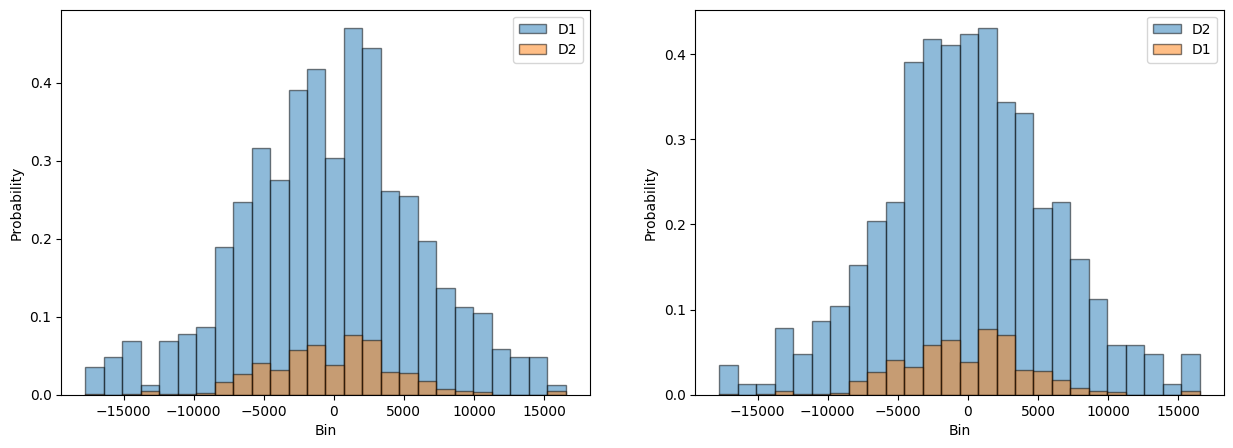

Testing:  12_2
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  0.07229356378140919
DP Predicate Test Result:  True


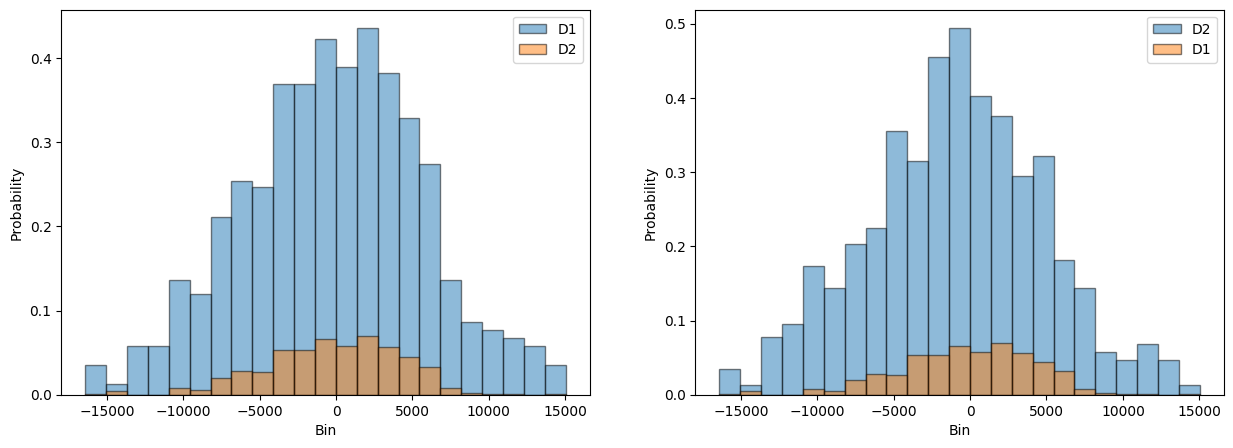

Testing:  1_1
Count of times noisy result within bounds: 472 / 500
Count of times noisy result outside bounds: 28 / 500
Mean signed deviation:  -1.8889527211131008
DP Predicate Test Result:  True


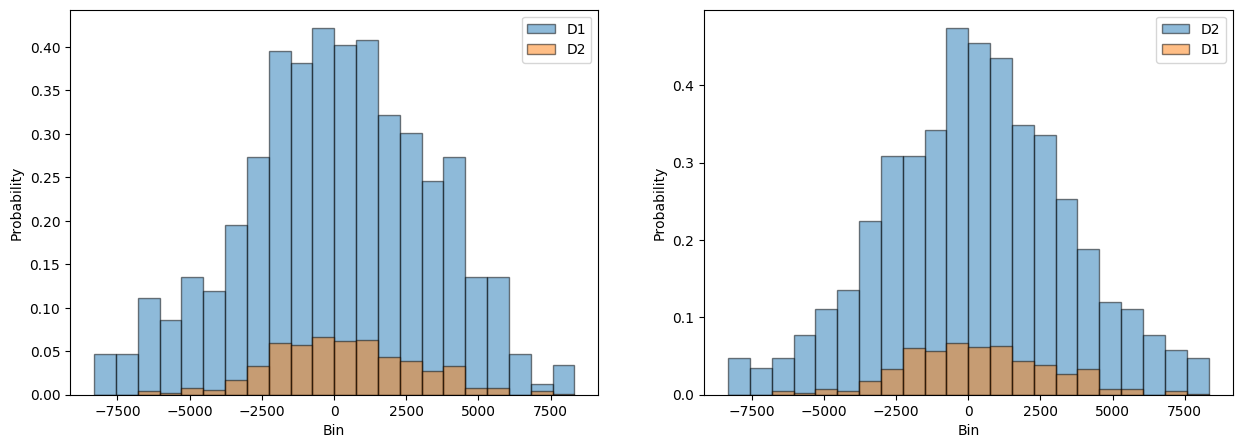

Testing:  012_1
Count of times noisy result within bounds: 479 / 500
Count of times noisy result outside bounds: 21 / 500
Mean signed deviation:  0.30861228951328556
DP Predicate Test Result:  True


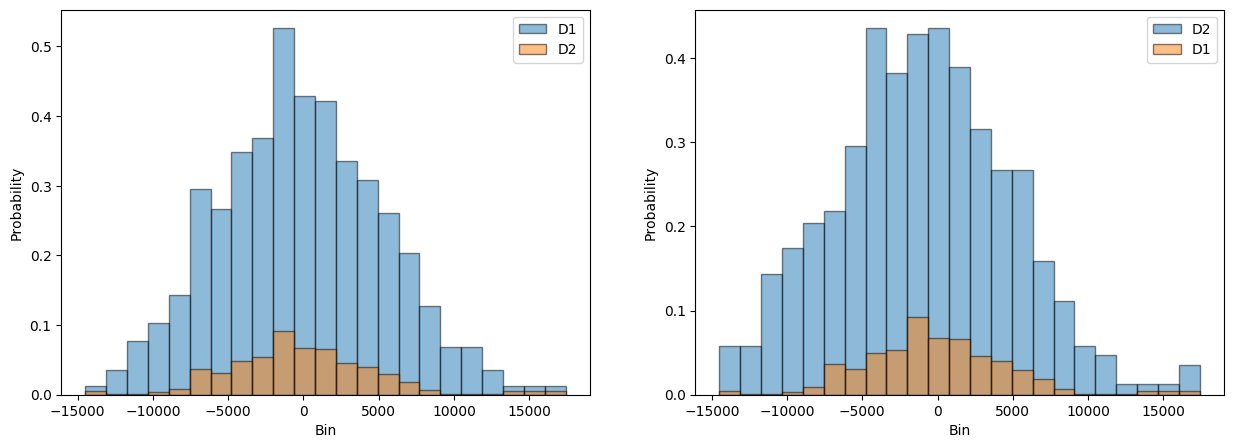

Testing:  02_0
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  -0.014666505028586447
DP Predicate Test Result:  True


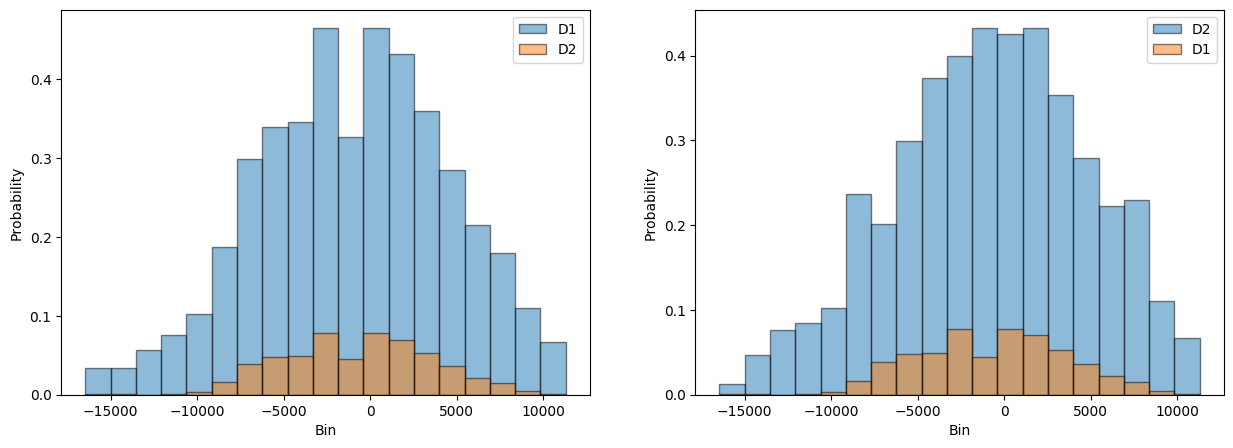

Testing:  02_2
Count of times noisy result within bounds: 475 / 500
Count of times noisy result outside bounds: 25 / 500
Mean signed deviation:  1.083890958019885
DP Predicate Test Result:  True


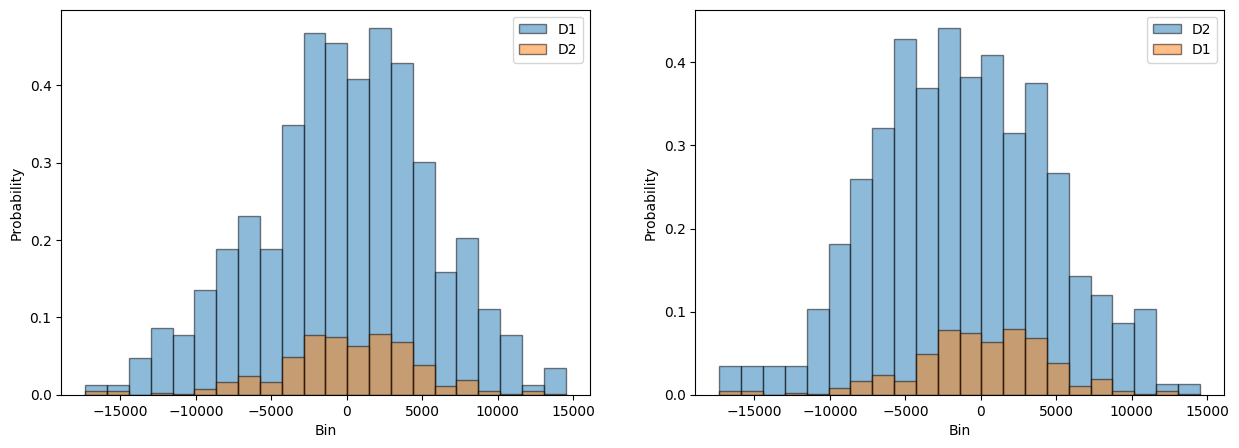

Testing:  0_0
Count of times noisy result within bounds: 0 / 500
Count of times noisy result outside bounds: 500 / 500
Mean signed deviation:  nan
DP Predicate Test Result:  True


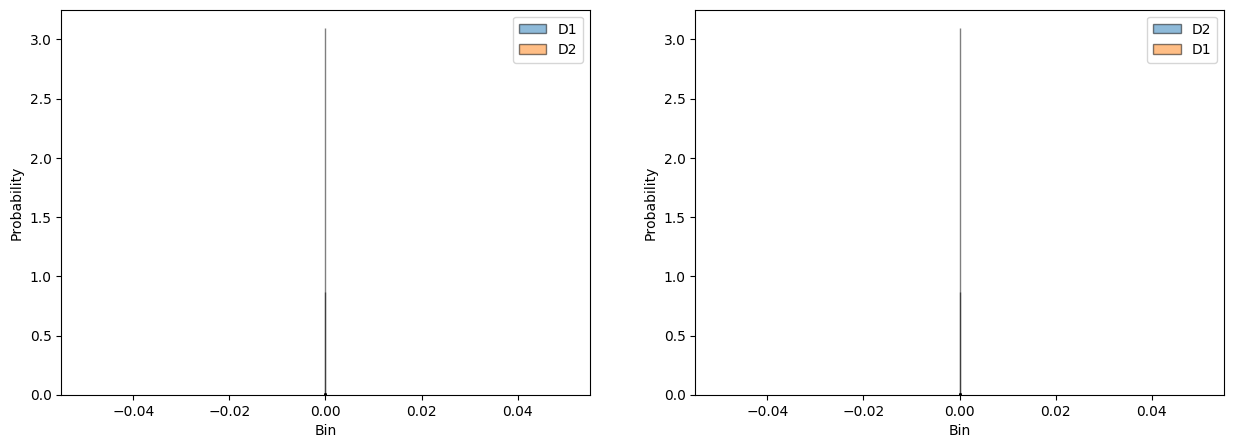

Testing:  012_2
Count of times noisy result within bounds: 482 / 500
Count of times noisy result outside bounds: 18 / 500
Mean signed deviation:  -0.042114970469605294
DP Predicate Test Result:  True


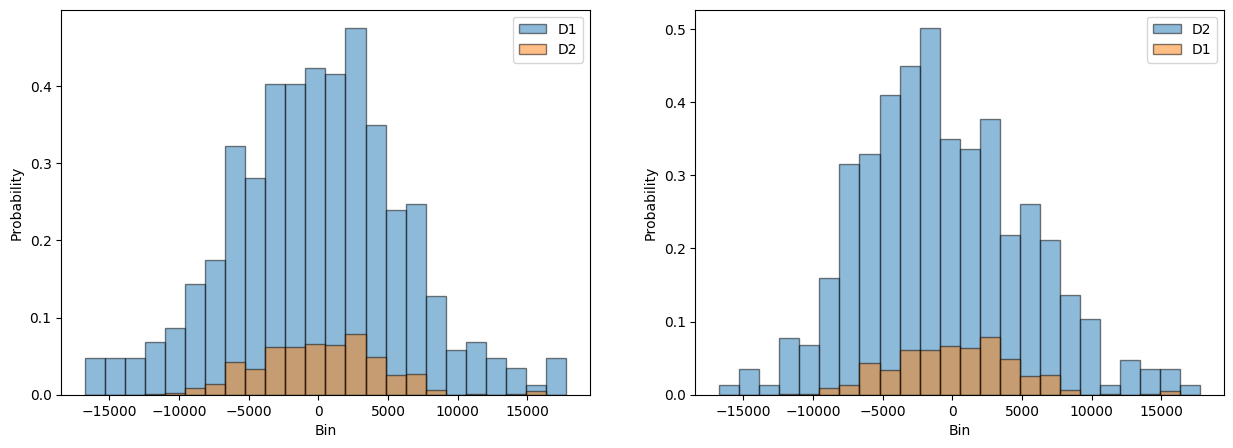

Testing:  01_0
Count of times noisy result within bounds: 473 / 500
Count of times noisy result outside bounds: 27 / 500
Mean signed deviation:  0.2361377028823293
DP Predicate Test Result:  True


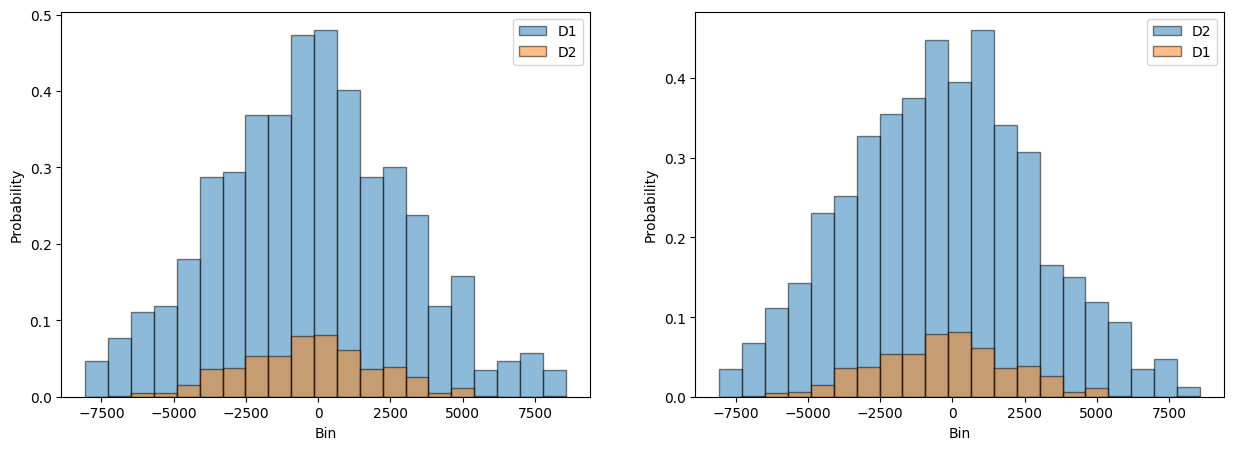

Testing:  01_1
Count of times noisy result within bounds: 474 / 500
Count of times noisy result outside bounds: 26 / 500
Mean signed deviation:  -0.29183245148066994
DP Predicate Test Result:  True


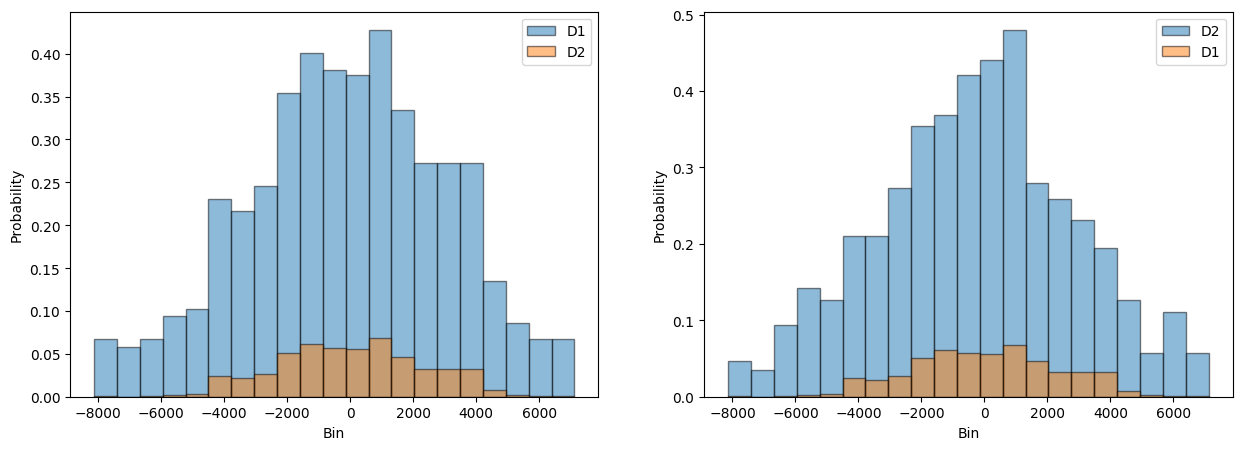

Test case:  [250.0, 555.5555555555554, -920.0]
Testing:  012_0
Count of times noisy result within bounds: 473 / 500
Count of times noisy result outside bounds: 27 / 500
Mean signed deviation:  0.015539670870004749
DP Predicate Test Result:  True


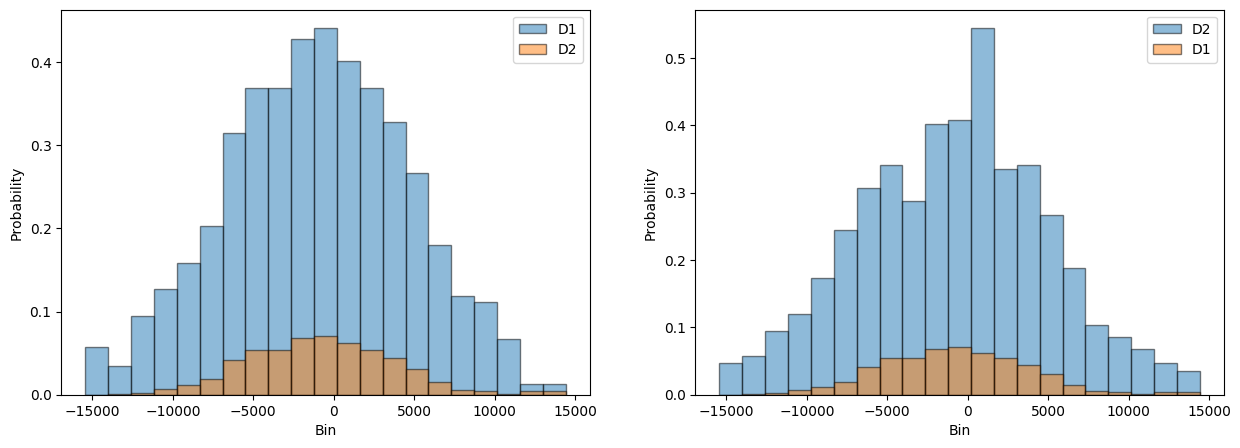

Testing:  12_1
Count of times noisy result within bounds: 471 / 500
Count of times noisy result outside bounds: 29 / 500
Mean signed deviation:  -0.21120183355578329
DP Predicate Test Result:  True


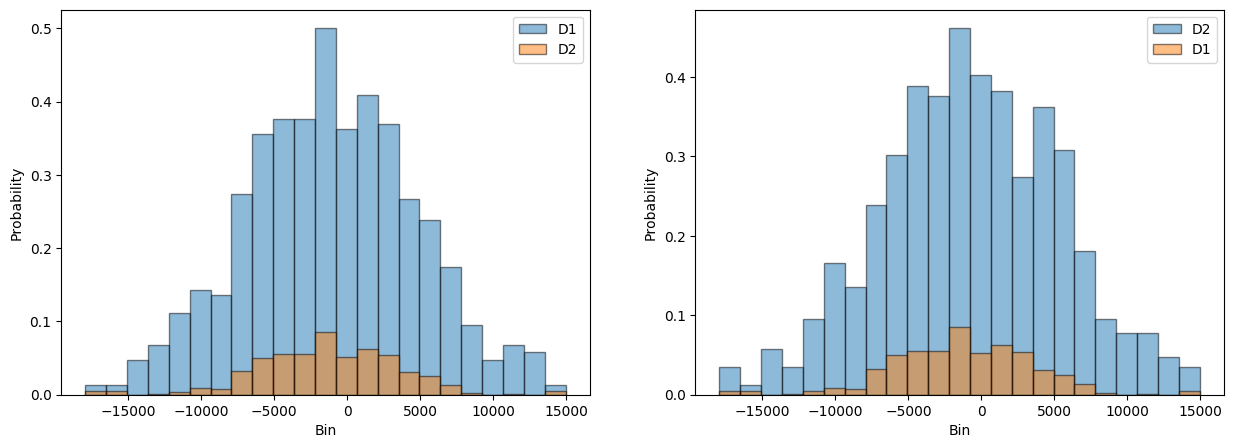

Testing:  2_2
Count of times noisy result within bounds: 474 / 500
Count of times noisy result outside bounds: 26 / 500
Mean signed deviation:  -0.5996973518338776
DP Predicate Test Result:  True


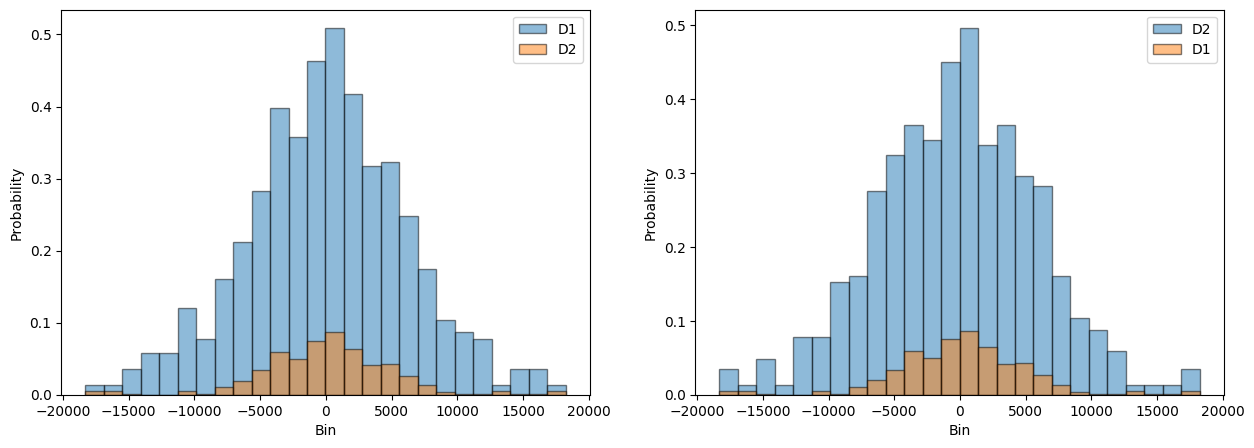

Testing:  12_2
Count of times noisy result within bounds: 475 / 500
Count of times noisy result outside bounds: 25 / 500
Mean signed deviation:  -0.1454466859486329
DP Predicate Test Result:  True


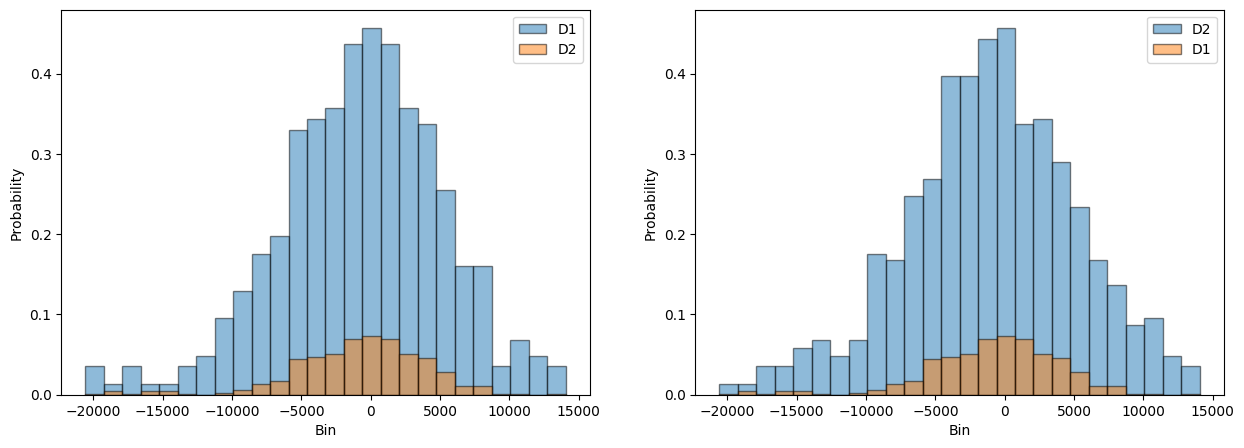

Testing:  1_1
Count of times noisy result within bounds: 471 / 500
Count of times noisy result outside bounds: 29 / 500
Mean signed deviation:  -0.9109078928149748
DP Predicate Test Result:  True


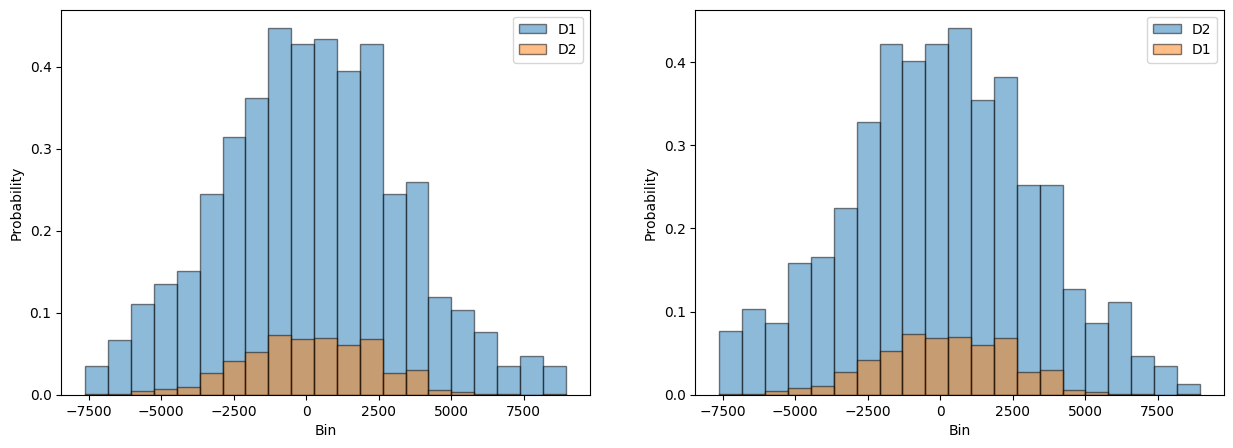

Testing:  012_1
Count of times noisy result within bounds: 470 / 500
Count of times noisy result outside bounds: 30 / 500
Mean signed deviation:  -0.05109309869950474
DP Predicate Test Result:  True


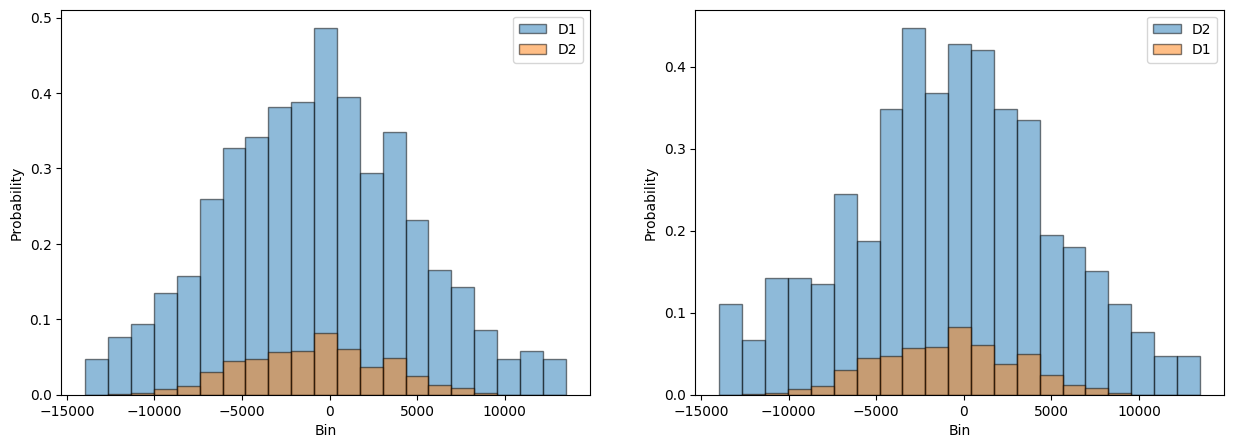

Testing:  02_0
Count of times noisy result within bounds: 478 / 500
Count of times noisy result outside bounds: 22 / 500
Mean signed deviation:  0.30049638840471443
DP Predicate Test Result:  True


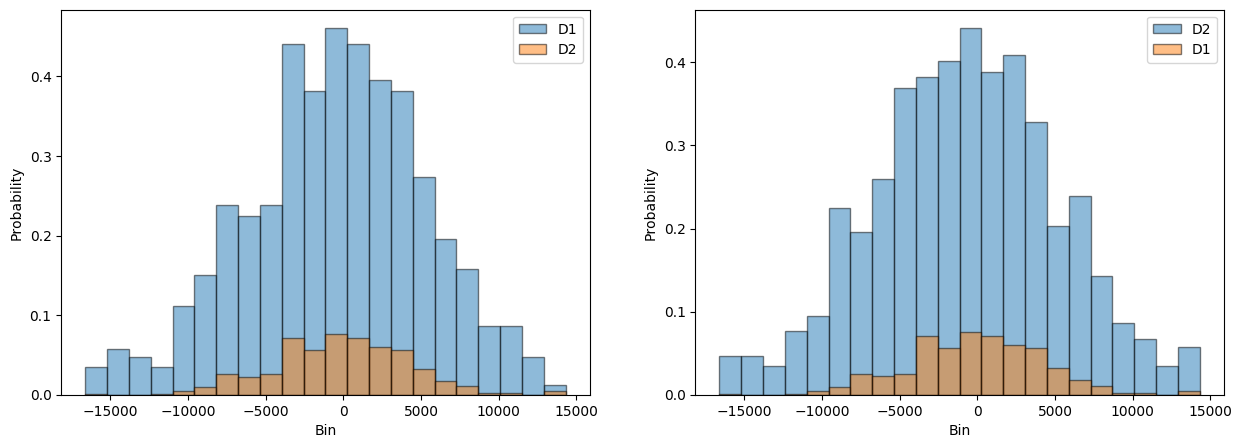

Testing:  02_2
Count of times noisy result within bounds: 476 / 500
Count of times noisy result outside bounds: 24 / 500
Mean signed deviation:  0.1734826144164657
DP Predicate Test Result:  True


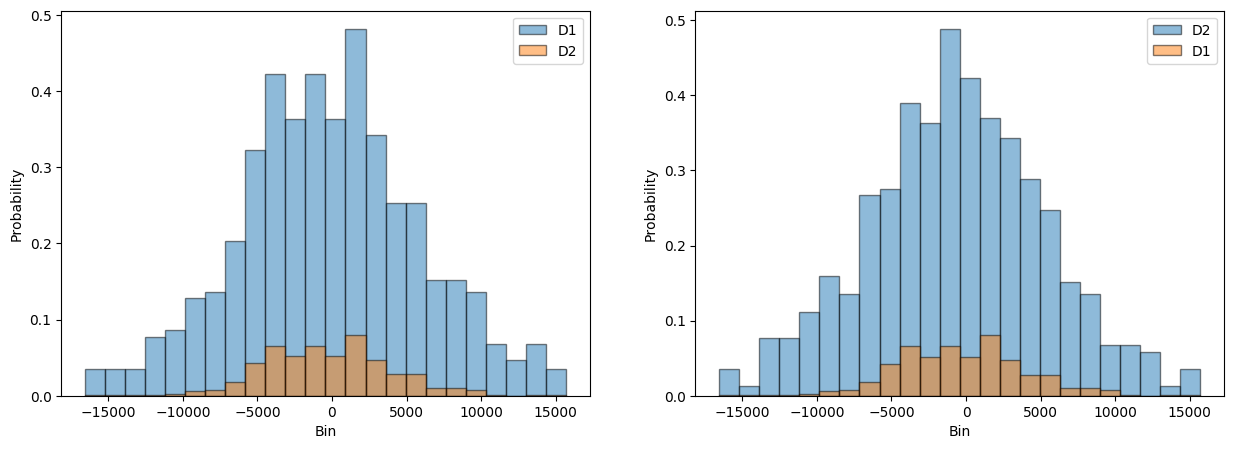

Testing:  0_0
Count of times noisy result within bounds: 0 / 500
Count of times noisy result outside bounds: 500 / 500
Mean signed deviation:  nan
DP Predicate Test Result:  True


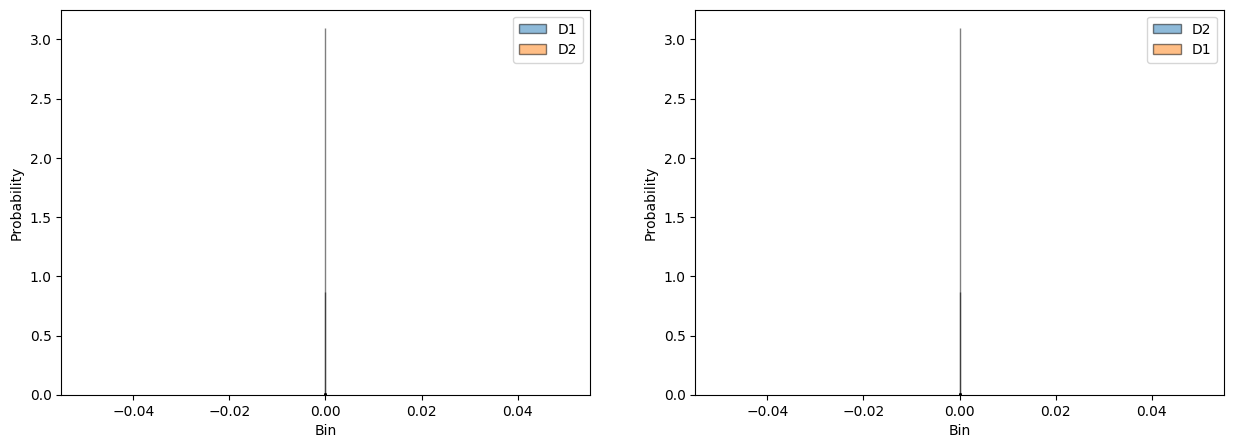

Testing:  012_2
Count of times noisy result within bounds: 481 / 500
Count of times noisy result outside bounds: 19 / 500
Mean signed deviation:  0.22637262588143986
DP Predicate Test Result:  True


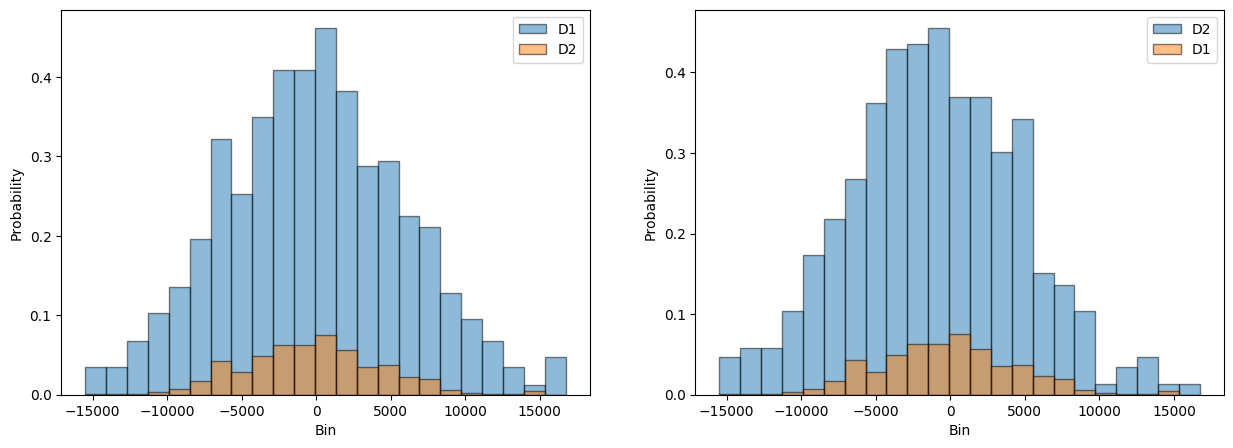

Testing:  01_0
Count of times noisy result within bounds: 473 / 500
Count of times noisy result outside bounds: 27 / 500
Mean signed deviation:  -0.03267274306822326
DP Predicate Test Result:  True


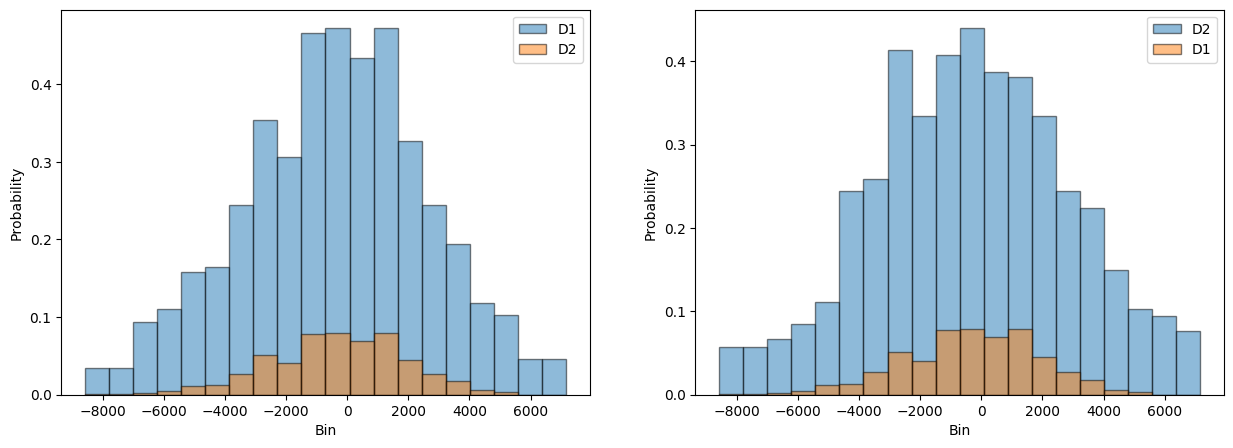

Testing:  01_1
Count of times noisy result within bounds: 479 / 500
Count of times noisy result outside bounds: 21 / 500
Mean signed deviation:  0.1993507824344453
DP Predicate Test Result:  True


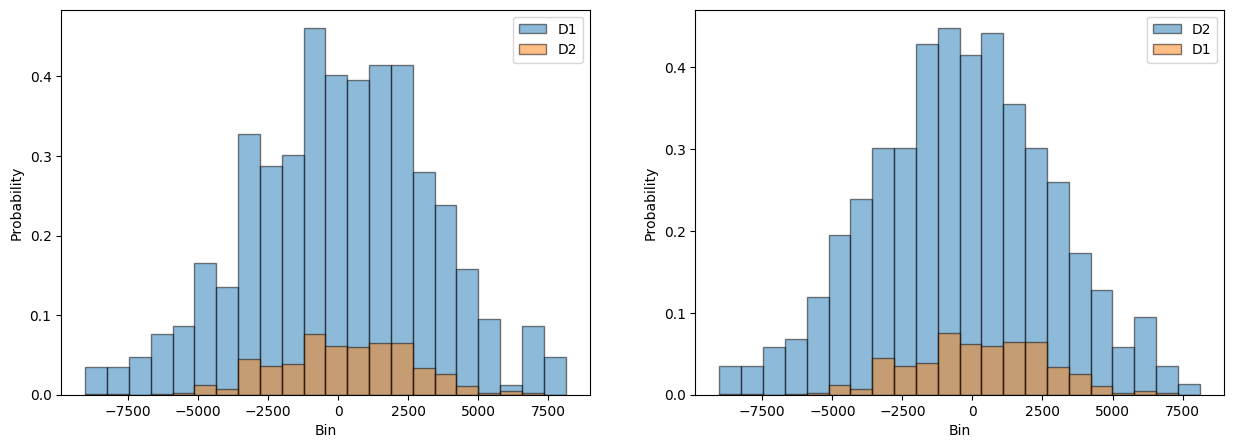

Halton sequence based Powerset Test Result
[0.0,-333.33333333333337,-600.0] - 012_0 - [True, True, True, 94.2, False, 0.5910494619640473]
[0.0,-333.33333333333337,-600.0] - 12_1 - [True, True, True, 96.2, False, 0.21613891802300633]
[0.0,-333.33333333333337,-600.0] - 2_2 - [True, True, True, 94.0, False, -0.7156634202357375]
[0.0,-333.33333333333337,-600.0] - 12_2 - [True, True, True, 94.0, False, 0.2258127463947124]
[0.0,-333.33333333333337,-600.0] - 1_1 - [True, True, True, 94.4, False, -0.9602676150152595]
[0.0,-333.33333333333337,-600.0] - 012_1 - [True, True, True, 93.8, False, 0.2874221484068832]
[0.0,-333.33333333333337,-600.0] - 02_0 - [True, True, True, 94.2, False, -0.5136574590878092]
[0.0,-333.33333333333337,-600.0] - 02_2 - [True, True, True, 94.2, False, 0.11933106163996281]
[0.0,-333.33333333333337,-600.0] - 0_0 - [True, False, True, 0.0, False, nan]
[0.0,-333.33333333333337,-600.0] - 012_2 - [True, True, True, 95.0, True, 0.007957423463514258]
[0.0,-333.33333333333337,-

In [27]:
start_time = time.time()
query_str = "SELECT SUM(Usage) AS TotalUsage FROM "
dp_res, acc_res, utility_res, bias_res = dv.dp_powerset_test(query_str, repeat_count=500, plot=True)
print("DP Predicate Test: ", dp_res)
print("Accuracy Test: ", acc_res)
print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))